# <center>Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

<b>Problem Statement 
<p>As a data scientist at a home electronics company which manufactures state of the art smart televisions. We want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
    </p>
    
•	Thumbs up		:  Increase the volume.<br>
•	Thumbs down		: Decrease the volume.<br>
•	Left swipe		: 'Jump' backwards 10 seconds.<br>
•	Right swipe		: 'Jump' forward 10 seconds. <br>
•	Stop			: Pause the movie. <br>


    

<b>Plan for Case Study
1.	Visualize the data
2.	Check for the class imbalance
3.	Build Generator
4.	Create a basic model to see if it trains well.
5.	Start building models.
6.	Validate the results using plots and its accuracy results.
7.	Get the ways to develop the model to get better results.
8.	Try using Different hyperparameters and create models using CONV3D, LSTM, GRU and even transfer learning, use augmentation even.
9.	Repeat the step 5 to 8 until best results (atleast 85% accuracy is achieved with a smaller number of parameters.
10.	Choose the best model and predict the class with the same.


In [1]:
import pandas as pd
import numpy as np
import os
from imageio.v3 import imread
import matplotlib.image as mpimg
from skimage.transform import resize,rotate
import datetime
import os
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.color import rgb2gray
from skimage.util import random_noise
import imgaug.augmenters as iaa
from IPython.display import Markdown, display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import mobilenet
from keras.applications.vgg16 import VGG16
import keras

In [2]:
!nvidia-smi

Sat Jan  7 07:52:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    14W /  70W |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## <center> Flow chart

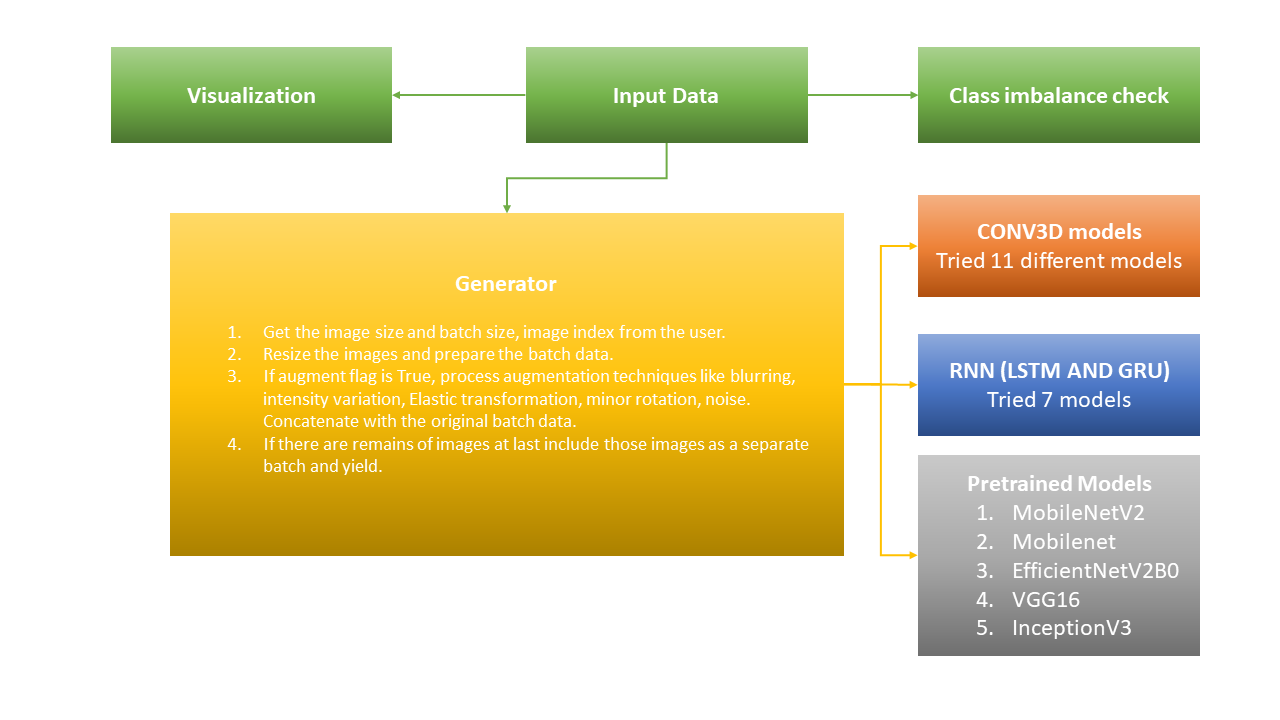

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size = 16,ip_img_size=(84,84),img_idx=[l for l in range(0,30,2)],augment=False):
    batch_size = batch_size
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            (y,z)=ip_img_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            # checking for augemnt flag
            if augment:
                batch_aug_data = np.zeros((batch_size,x,y,z,3))
                batch_aug_labels = np.zeros((batch_size,5))
                
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                                           
                        
                    #crop the images and resize them. Note that the images are of 2 different shape
                    image = resize(image, (ip_img_size))
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255#normalise and feed in the image
                    
                    if augment:
                        image_aug = image
                        if idx%3==0:
                            image_aug = ndimage.uniform_filter(image_aug) #apply bluring to image 
                            image_aug = image_aug * 0.70 # differ the intensity of the image
                            
                        #image_aug = rgb2gray(image_aug)
                        if idx%4==0:
                            image_aug = image_aug * 0.85 # differ the intensity of the image
                            image_aug = iaa.ElasticTransformation(alpha=40.0, sigma=2.5).augment_image(image_aug)
                            # give some watery effect to the image
                            
                        if idx%2==0:
                            image_aug = rotate(image_aug, angle=5) # rotation
                            
                        else:
                            image_aug = rotate(image_aug, angle=-7) #rotation 
                            image_aug = random_noise(image_aug, var=0.1**.01) # including random noise
                            
                        image_aug = resize(image_aug,(ip_img_size)) # resizing to the required size
                        
                        batch_aug_data[folder,idx,:,:,0] = (image_aug[:,:,0])/255#normalise and feed in the image
                        batch_aug_data[folder,idx,:,:,1] = (image_aug[:,:,1])/255#normalise and feed in the image
                        batch_aug_data[folder,idx,:,:,2] = (image_aug[:,:,2])/255#normalise and feed in the image
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                #batch_aug_labels = batch_labels
            
            if augment:
                # concatenating the original image batch with the augmented image batch will increase the batch size as twice
                # increases the image folders count also twice.
                
                batch_data = np.concatenate([batch_data,batch_aug_data])
                batch_labels = np.concatenate([batch_labels,batch_labels])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t)%(batch_size)!=0:
            x=len(img_idx)
            (y,z)=ip_img_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    image = resize(image, (ip_img_size))
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255#normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
# Checking for Class imbalance in training dataset

pd.read_csv('Project_data/train.csv',sep=';')['0'].value_counts()

1    137
3    137
0    135
2    130
4    123
Name: 0, dtype: int64

In [7]:
# Checking for Class imbalance in validation dataset

pd.read_csv('Project_data/val.csv',sep=';')['0'].value_counts()

1    23
2    22
3    21
0    17
4    16
Name: 0, dtype: int64

C:\Users\sthul\AppData\Local\Temp\ipykernel_11624\38343692.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2,2))


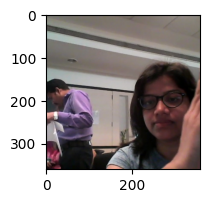

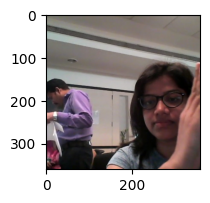

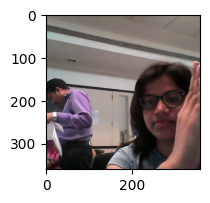

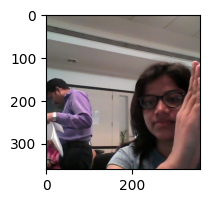

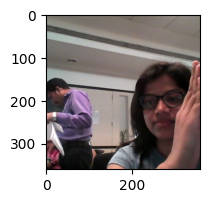

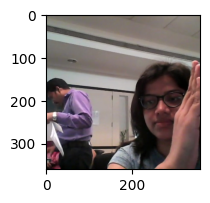

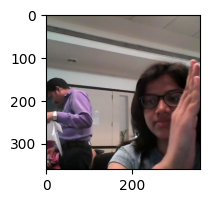

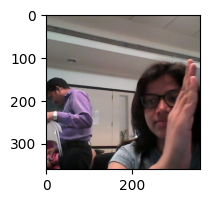

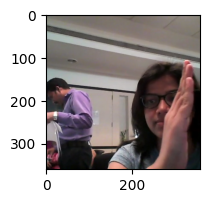

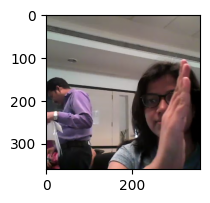

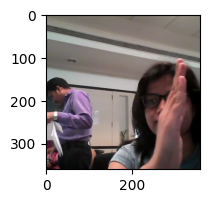

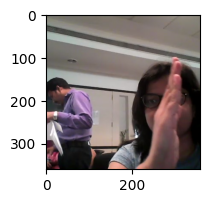

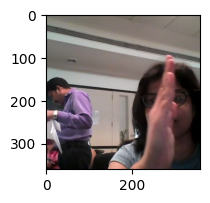

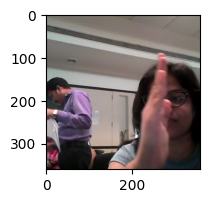

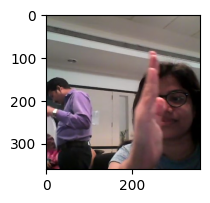

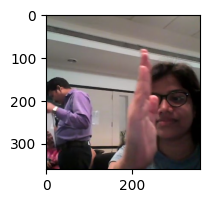

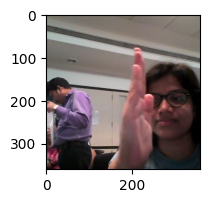

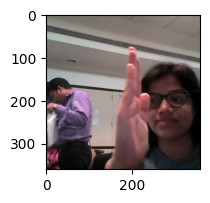

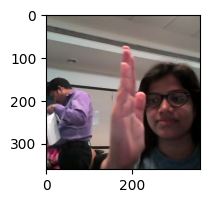

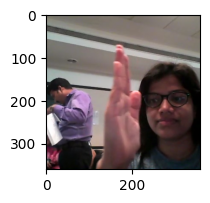

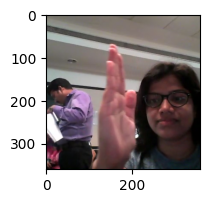

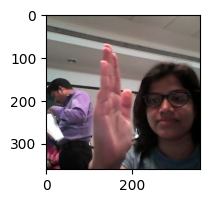

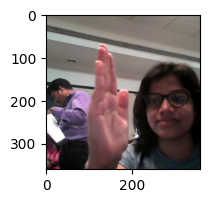

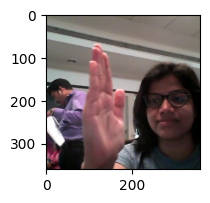

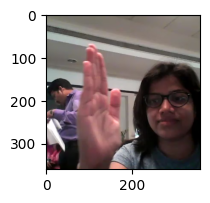

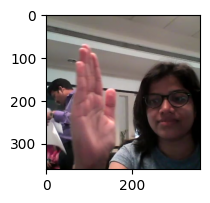

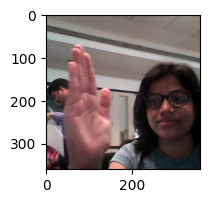

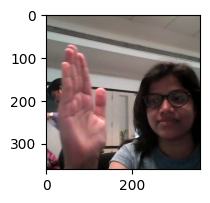

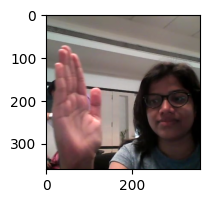

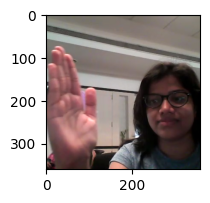

In [8]:
#Viewing sample images in single folder
path = 'S:/PG DS/Deep learning/Case Study/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/'
for file in os.listdir(path):
    image = mpimg.imread(path+file)
    # <something gets done here>
    plt.figure(figsize=(2,2))
    plt.imshow(image)

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = r'Project_data\train'
val_path = r'Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Base Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
#write your model here

# Trying with a simple basic model with few layers


model = Sequential()
model.add(Conv3D(16, 3, padding='same',input_shape=(15,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 84, 84, 16)    1312      
                                                                 
 activation (Activation)     (None, 15, 84, 84, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 15, 84, 84, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 42, 42, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 42, 42, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 7, 42, 42, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
# Trying with batch size as 64
batch_size = 64
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'Base_Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.000001)# write the REducelronplateau code here monitor='val_loss', patience, min_lr
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=4)
callbacks_list = [checkpoint, LR,early_stopping]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
Model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\sthul\AppData\Local\Temp\ipykernel_11624\2063873716.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  Project_data\train ; batch size = 64
Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/batch_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_11624\2063873716.py", line 1, in <module>
      Model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/batch_normalization/FusedBatchNormV3'
OOM when allocating tensor with shape[64,16,15,7056] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/batch_normalization/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1387]

There is OOM error and hence now trying with batch size of 32

### Base Model V2

In [19]:
# Trying with batch size as 32
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'Base_Model' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, min_lr=0.000001)# write the REducelronplateau code here monitor='val_loss', patience, min_lr
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=4)
callbacks_list = [checkpoint, LR,early_stopping]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
Model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data\train ; batch size = 32


C:\Users\sthul\AppData\Local\Temp\ipykernel_11624\3072999055.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.2217 - categorical_accuracy: 0.5446Source path =  Project_data\val ; batch size = 32

Epoch 1: saving model to Base_Model_2023-01-0607_54_10.463991\model-00001-1.22169-0.54464-1.76250-0.30469.h5
21/21 [==============================] - 103s 5s/step - loss: 1.2217 - categorical_accuracy: 0.5446 - val_loss: 1.7625 - val_categorical_accuracy: 0.3047 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.5539 - categorical_accuracy: 0.8095
Epoch 2: saving model to Base_Model_2023-01-0607_54_10.463991\model-00002-0.55387-0.80952-2.26513-0.23438.h5
21/21 [==============================] - 68s 3s/step - loss: 0.5539 - categorical_accuracy: 0.8095 - val_loss: 2.2651 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.3276 - categorical_accuracy: 0.9107
Epoch 3: saving model to Base_Model_2023-01-0607_54_10.463991\model-00003-0.32759

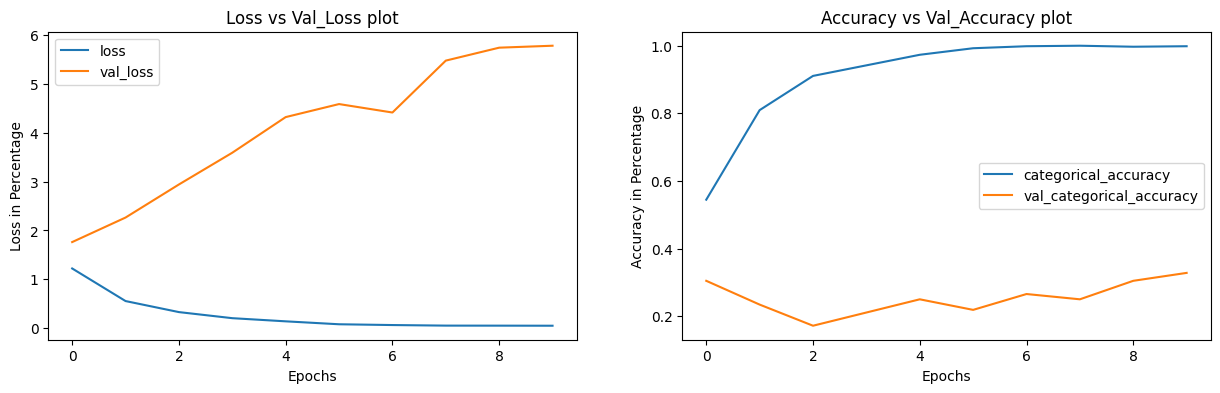

In [20]:
# plotting the loss and accuracy curve

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(Model_history.history['loss'])   
axes[0].plot(Model_history.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[0].set_title('Loss vs Val_Loss plot')
axes[0].set_xlabel('Epochs', visible=True)
axes[0].set_ylabel('Loss in Percentage', visible=True)
axes[1].plot(Model_history.history['categorical_accuracy'])   
axes[1].plot(Model_history.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
axes[1].set_title('Accuracy vs Val_Accuracy plot')
axes[1].set_xlabel('Epochs', visible=True)
axes[1].set_ylabel('Accuracy in Percentage', visible=True)

plt.show()

<b>From the plot we could see clearly the model is over fitting 

In [6]:
# Creating fuctions for ease of access

def compile_(model,optimiser=optimizers.Adam(),loss='categorical_crossentropy',metrics=['categorical_accuracy']):
    '''Function to Compile the model by using the supplied optimiser.'''
    model.compile(optimizer=optimiser, loss=loss, metrics=metrics)
    print(model.summary())
    return model


def fit_model(model,epoch,train_doc,val_doc,batch_size,name='Model',ip_img_size=(84,84),img_idx=[l for l in range(0,30,2)],
              min_lr=0.00001,lr_reduce_factor=0.2,es_monitor = 1,es_patience=4,augment=False):
    '''
    Function performs the following action 
        1. Get the path for the model saving.
        2. Get the train and the validation generators according to the Batch size.
        3. Prepare the Call backs for the model training.
        4. Calculate the steps per Epoch based on Batch size.
        5. Train the model using model.fit
        6. Return the trained model and model folder location.
        7. Early Stopping 
            a. es_monitor: 
                1 - categorical_accuracy
                2 - val_categorical_accuracy
            b. es_patience
    '''
    curr_dt_time = datetime.datetime.now()
    train_path = r'Project_data\train'
    val_path = r'Project_data\val'
    num_train_sequences = len(train_doc)
    print('\n# Training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# Validation sequences =', num_val_sequences)
    num_epochs = epoch # choose the number of epochs
    no_batch=int(num_train_sequences/batch_size)
    if num_train_sequences%(batch_size)!=0:
        no_batch = no_batch+1
    print('# Total number of batches per epoch =',no_batch)
    print(' ')
    print('-'*100)
    
    #####################################################################################
    train_generator = generator(train_path, train_doc,ip_img_size=ip_img_size,batch_size=batch_size,img_idx=img_idx,augment=augment)
    val_generator = generator(val_path, val_doc,ip_img_size=ip_img_size,batch_size=batch_size,img_idx=img_idx,augment=augment)
    model_name = name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    #####################################################################################
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    
    filepath = model_name + name + '-epoch_{epoch:05d}-loss_{loss:.5f}-cat_acc_{categorical_accuracy:.5f}-val_loss_{val_loss:.5f}-val_acc_{val_categorical_accuracy:.5f}.h5'
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    # ModelCheckpoint - saves weight and model after every epoch
    LR = ReduceLROnPlateau(monitor='val_loss', factor=lr_reduce_factor, verbose=1, patience=3,min_lr=min_lr)# write the REducelronplateau code here monitor='val_loss', patience, min_lr
    # Adding Early stopping to stop training if the accuracy stops increasing after certain number of epochs.
    if es_monitor == 2:
        monitor = 'val_categorical_accuracy'
    else:
        monitor = 'categorical_accuracy'
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=es_patience) 
    callbacks_list = [checkpoint, LR,early_stopping]
    
    ######################################################################################
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    ######################################################################################
    # Here we can use fit directly since for this version fit trains for generator input as well 
    # so inorder to avoid warnings, using fit directly.
    return [model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0),model_name]


def plot(history,model_path='$'):
    '''Function to plot the results from the trained model and save it in the location provided.'''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'],loc='best')
    axes[0].set_title('Loss vs Val_Loss plot')
    axes[0].set_xlabel('Epochs', visible=True)
    axes[0].set_ylabel('Loss', visible=True)

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'],loc='best')
    axes[1].set_title('Accuracy vs Val_Accuracy plot')
    axes[1].set_xlabel('Epochs', visible=True)
    axes[1].set_ylabel('Accuracy', visible=True)
    if model_path !='$':
        # to save the plot as an png image if the path is provided.
        fig.savefig(model_path,dpi=200,format='png')
    
def best_model(history,model_path='$'):
    '''To get the Model within the epochs trained having the 
    minimum difference between Training Accuracy and Validation Accuracy'''
    
    df = pd.DataFrame(history.history)
    df['Epoch'] = np.arange(1,len(df)+1)
    df['Acc_val-acc_diff'] = abs(df['categorical_accuracy'] - df['val_categorical_accuracy'])
    if model_path!='$':
        # To save the model performance in csv file for later reference if required
        df.to_csv(model_path,index = False, header=True)
    df.set_index('Epoch',inplace=True)
    print('\n')
    display(Markdown("<span style='color:brown'>**Model performance across Epochs**</span>"))
    display(df)
    df_min=df[df['val_categorical_accuracy'] >= 0.70]
    
    if len(df_min) !=0:
        df_min=df_min[df_min['Acc_val-acc_diff'] == min(df_min['Acc_val-acc_diff'])]
        print('\n')
        display(Markdown("<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>"))
        display(df_min)
    else:
        display(Markdown("<span style='color:red'>**This Model has maximum Validation Accuracy less than 70% and is recomended not to use**</span>"))
        
    df_max=df[df['val_categorical_accuracy'] == max(df['val_categorical_accuracy'])]
    print('\n')
    display(Markdown("<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>"))
    display(df_max)
    
    
def train_model(model,epoch,train_doc,val_doc,batch_size=16,name='Model',ip_img_size=(84,84),img_idx=[l for l in range(0,30,2)],
               lr_reduce_factor=0.2,min_lr=0.00001,es_monitor = 1,es_patience=4,augment=False):
    '''
    Function performs the following action 
    a. Call the function fit_model to perform the below functions
        1. Get the path for the model saving
        2. Get the train and the validation generators according to the Batch size.
        3. Prepare the Call backs for the model training.
        4. Calculate the steps per Epoch based on Batch size.
        5. Train the model using model.fit
        6. Return the trained model and model folder location.
        7. Early Stopping 
            a. es_monitor: 
                1 - categorical_accuracy
                2 - val_categorical_accuracy
            b. es_patience
        8. Augmentation True includes uniform filter, noise inclusion and rotation.
    b. Call the function plot to plt the results of the training
    c. To call the function best_model to display the epoch number and its parameters having best results.
    '''
    if es_monitor == 1:
        monitor = 'categorical_accuracy'
    else:
        monitor = 'val_categorical_accuracy'
    print("Hyperparameter values-")
    print("     1. Epoch:",epoch)
    print("     2. Crop size of Frame:",ip_img_size)
    print("     3. Learning rate reduction factor:",lr_reduce_factor)
    print("     4. Batch Size:",batch_size)
    print("     5. Minimum Learning Rate:", min_lr)
    print("     6. Image indices:",img_idx, 'having length', len(img_idx))
    print("     7. Early Stopping monitor value:",es_monitor,"-",monitor)
    print("     8. Early stopping patience value:",es_patience)
    print("     9. Augmentation:",augment)
    
    if augment:
        print("\nThe given batch size is",batch_size, "but the actual batch size post augmentation is", batch_size*2,
             "\nAlso the training data length is not 663 but 663*2= 1326, hence the number of batches is same.")
    
    [history,model_path] = fit_model(model,epoch,train_doc,val_doc,batch_size=batch_size,name=name,min_lr=min_lr,
                                     ip_img_size=ip_img_size,img_idx=img_idx,lr_reduce_factor=lr_reduce_factor,
                                    es_monitor = es_monitor,es_patience=es_patience,augment=augment)
    print(' ')
    if len(history.history['lr'])< epoch:
        print("Since the Accuracy was not increasing for the past",es_patience,"epochs, Early stopping is in action to stop the training by"
              ,len(history.history['lr']),'instead of',epoch)
        print(' ')
        display(Markdown("<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>"))
    else:
        print(' ')
        display(Markdown("<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>"))
    plot(history,model_path+name+'performance_history_plot.png')
    print('')
    best_model(history=history,model_path=model_path+name+'performance_history.csv')
    return history


### Model 1

In [13]:
model = Sequential()
model.add(Conv3D(16, 3, padding='same',input_shape=(15,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [14]:
model = compile_(model=model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 15, 84, 84, 16)    1312      
                                                                 
 activation_8 (Activation)   (None, 15, 84, 84, 16)    0         
                                                                 
 batch_normalization_16 (Bat  (None, 15, 84, 84, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 42, 42, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 7, 42, 42, 32)     13856     
                                                                 
 activation_9 (Activation)   (None, 7, 42, 42, 32)    

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (84, 84)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 32
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 21
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 32
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.3607 - categorical_accuracy: 0.4777Source path =  Project_data\val ; batch size = 32

Epoch 1: saving model to Model1_2023-01-0608_18_47.635190\Model1-epoch_00001-loss_1.36075-cat_acc_0.47768-val_loss_2.13040-val_acc_0.17188.h5
21/21 [==============================] 

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.360748              0.477679  2.130404                  0.171875   
2      0.770173              0.702381  5.133088                  0.171875   
3      0.591107              0.776786  4.828686                  0.226562   
4      0.384558              0.875000  5.717086                  0.210938   
5      0.300020              0.897321  5.464697                  0.210938   
6      0.218141              0.936012  5.858752                  0.187500   
7      0.185900              0.949405  5.092618                  0.210938   
8      0.171061              0.961310  5.135162                  0.226562   
9      0.172218              0.952381  5.164264                  0.203125   
10     0.133413              0.976190  4.918715                  0.187500   
11     0.128007              0.964286  5.085634                  0.187500   
12     0.127901              0.974702  4.720219                  0.234375   
13     0.131240              0.974702  4.661201                  0.242188   
14     0.143251              0.968750  4.598097                  0.226562   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.305804  
2      0.00100          0.530506  
3      0.00100          0.550223  
4      0.00100          0.664062  
5      0.00020          0.686384  
6      0.00020          0.748512  
7      0.00020          0.738467  
8      0.00004          0.734747  
9      0.00004          0.749256  
10     0.00004          0.788690  
11     0.00001          0.776786  
12     0.00001          0.740327  
13     0.00001          0.732515  
14     0.00001          0.742188

<span style='color:red'>**This Model has maximum Validation Accuracy less than 70% and is recomended not to use**</span>

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                      
13     0.13124              0.974702  4.661201                  0.242188   

            lr  Acc_val-acc_diff  
Epoch                             
13     0.00001          0.732515

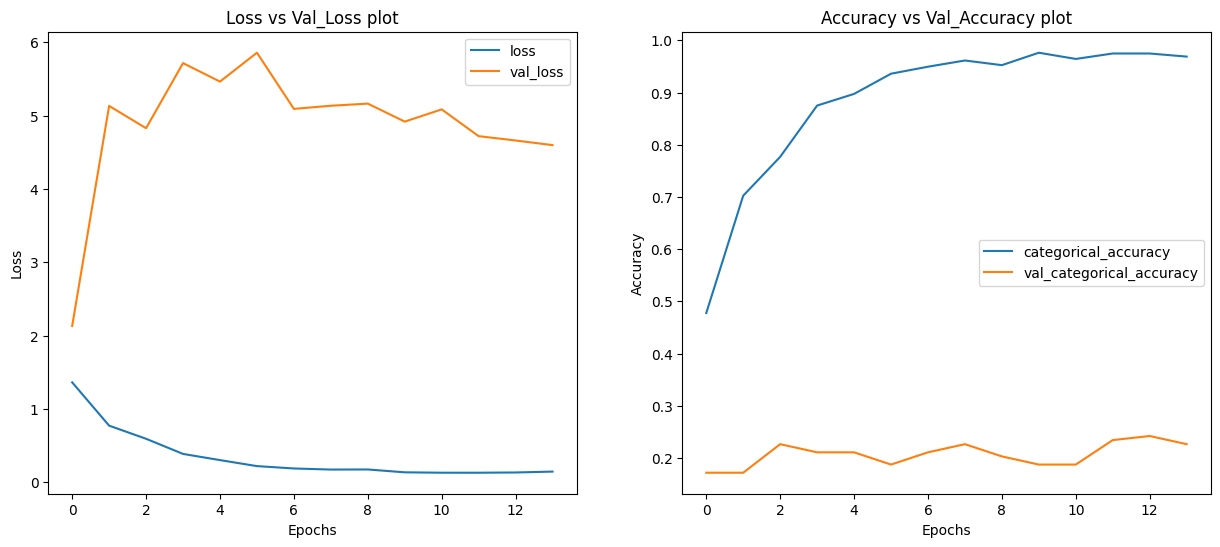

In [24]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model1',batch_size=32)

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (84, 84)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.5068 - categorical_accuracy: 0.4554Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model1_2023-01-0210_01_47.747887\Model1-epoch_00001-loss_1.50680-cat_acc_0.45536-val_loss_2.77225-val_acc_0.25000.h5
42/42 [==============================] 

42/42 [==============================] - 62s 1s/step - loss: 0.0717 - categorical_accuracy: 0.9911 - val_loss: 0.4321 - val_categorical_accuracy: 0.8661 - lr: 2.0000e-04
Epoch 19/25
42/42 [==============================] - ETA: 0s - loss: 0.0630 - categorical_accuracy: 0.9866
Epoch 19: saving model to Model1_2023-01-0210_01_47.747887\Model1-epoch_00019-loss_0.06296-cat_acc_0.98661-val_loss_0.56005-val_acc_0.79464.h5
42/42 [==============================] - 61s 1s/step - loss: 0.0630 - categorical_accuracy: 0.9866 - val_loss: 0.5601 - val_categorical_accuracy: 0.7946 - lr: 2.0000e-04
Epoch 20/25
42/42 [==============================] - ETA: 0s - loss: 0.0521 - categorical_accuracy: 0.9911
Epoch 20: saving model to Model1_2023-01-0210_01_47.747887\Model1-epoch_00020-loss_0.05212-cat_acc_0.99107-val_loss_0.75088-val_acc_0.75893.h5

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
42/42 [==============================] - 62s 2s/step - loss: 0.0521 - categorical

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.506803              0.455357  2.772253                  0.250000   
2      1.087773              0.593750  2.433596                  0.294643   
3      0.828708              0.705357  2.864839                  0.276786   
4      0.555047              0.773810  3.801111                  0.232143   
5      0.429983              0.846726  3.783911                  0.294643   
6      0.299144              0.909226  3.257270                  0.276786   
7      0.248737              0.916667  2.745266                  0.258929   
8      0.209576              0.940476  2.403238                  0.348214   
9      0.170400              0.958333  1.793371                  0.517857   
10     0.143981              0.968750  1.474699                  0.589286   
11     0.146143              0.955357  0.896783                  0.687500   
12     0.136729              0.965774  0.973951                  0.633929   
13     0.119606              0.965774  0.645143                  0.812500   
14     0.094413              0.971726  0.524436                  0.785714   
15     0.108585              0.973214  0.497509                  0.803571   
16     0.076464              0.986607  0.559111                  0.776786   
17     0.074466              0.986607  0.391279                  0.839286   
18     0.071716              0.991071  0.432105                  0.866071   
19     0.062964              0.986607  0.560053                  0.794643   
20     0.052120              0.991071  0.750880                  0.758929   
21     0.048030              0.995536  0.367775                  0.875000   
22     0.051420              0.991071  0.316540                  0.875000   
23     0.053666              0.992560  0.319494                  0.892857   
24     0.034560              1.000000  0.353742                  0.839286   
25     0.045724              0.994048  0.290495                  0.883929   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.205357  
2      0.00100          0.299107  
3      0.00100          0.428571  
4      0.00100          0.541667  
5      0.00100          0.552083  
6      0.00020          0.632440  
7      0.00020          0.657738  
8      0.00020          0.592262  
9      0.00020          0.440476  
10     0.00020          0.379464  
11     0.00020          0.267857  
12     0.00020          0.331845  
13     0.00020          0.153274  
14     0.00020          0.186012  
15     0.00020          0.169643  
16     0.00020          0.209821  
17     0.00020          0.147321  
18     0.00020          0.125000  
19     0.00020          0.191964  
20     0.00020          0.232143  
21     0.00004          0.120536  
22     0.00004          0.116071  
23     0.00004          0.099702  
24     0.00004          0.160714  
25     0.00004          0.110119

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
23     0.053666               0.99256  0.319494                  0.892857   

            lr  Acc_val-acc_diff  
Epoch                             
23     0.00004          0.099702

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
23     0.053666               0.99256  0.319494                  0.892857   

            lr  Acc_val-acc_diff  
Epoch                             
23     0.00004          0.099702

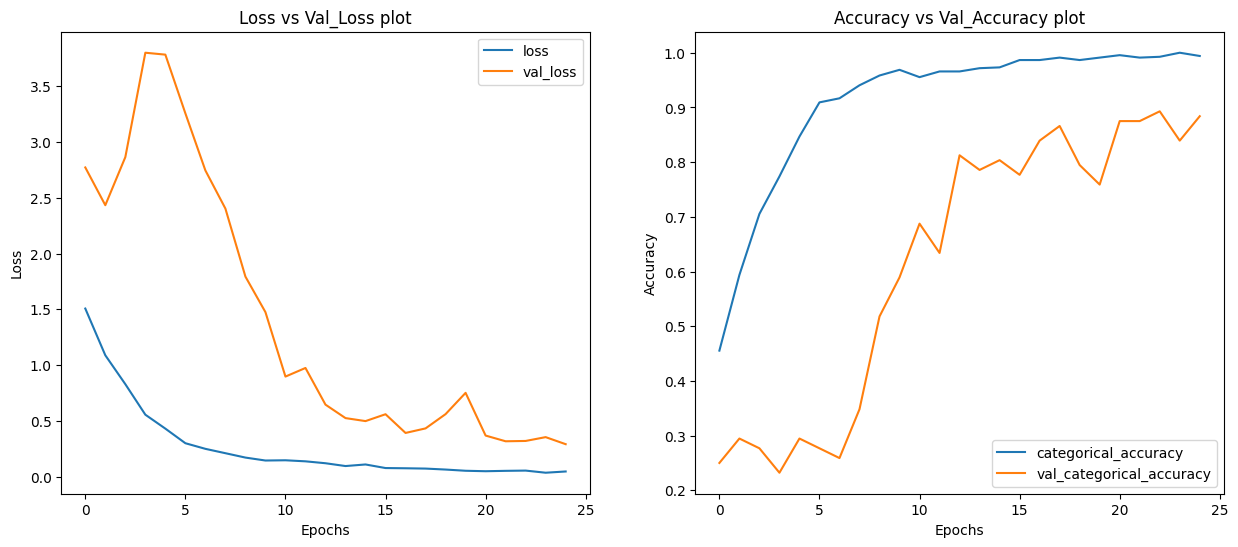

In [11]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model1')

### Model 2

In [12]:
### Lets increase the image size to 120*120 and add in some layers and try and train

In [15]:
model = Sequential()
model.add(Conv3D(16, 3, padding='same',input_shape=(15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [16]:
model = compile_(model=model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_22 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 7, 60, 60, 32)    

In [17]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model2',ip_img_size=(120,120),batch_size=32)

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (120, 120)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 32
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 21
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 32
Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_3/batch_normalization_22/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\1140208724.py", line 1, in <module>
      Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model2',ip_img_size=(120,120),batch_size=32)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 171, in train_model
      [history,model_path] = fit_model(model,epoch,train_doc,val_doc,batch_size=batch_size,name=name,min_lr=min_lr,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 77, in fit_model
      return [model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_3/batch_normalization_22/FusedBatchNormV3'
OOM when allocating tensor with shape[32,16,15,14400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/batch_normalization_22/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10892]

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (120, 120)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.4909 - categorical_accuracy: 0.4509Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model2_2023-01-0210_28_17.341346\Model2-epoch_00001-loss_1.49089-cat_acc_0.45089-val_loss_1.93313-val_acc_0.16071.h5
42/42 [==============================

42/42 [==============================] - 69s 2s/step - loss: 0.1371 - categorical_accuracy: 0.9717 - val_loss: 0.7632 - val_categorical_accuracy: 0.7321 - lr: 1.0000e-05
Epoch 19/25
42/42 [==============================] - ETA: 0s - loss: 0.1614 - categorical_accuracy: 0.9598
Epoch 19: saving model to Model2_2023-01-0210_28_17.341346\Model2-epoch_00019-loss_0.16138-cat_acc_0.95982-val_loss_0.54172-val_acc_0.83036.h5
42/42 [==============================] - 69s 2s/step - loss: 0.1614 - categorical_accuracy: 0.9598 - val_loss: 0.5417 - val_categorical_accuracy: 0.8304 - lr: 1.0000e-05
Epoch 20/25
42/42 [==============================] - ETA: 0s - loss: 0.1515 - categorical_accuracy: 0.9598
Epoch 20: saving model to Model2_2023-01-0210_28_17.341346\Model2-epoch_00020-loss_0.15150-cat_acc_0.95982-val_loss_0.61736-val_acc_0.75893.h5
42/42 [==============================] - 69s 2s/step - loss: 0.1515 - categorical_accuracy: 0.9598 - val_loss: 0.6174 - val_categorical_accuracy: 0.7589 - lr: 1

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.490890              0.450893  1.933130                  0.160714   
2      0.692886              0.718750  2.522331                  0.276786   
3      0.512801              0.812500  3.084044                  0.267857   
4      0.364848              0.879464  3.393960                  0.196429   
5      0.312348              0.900298  3.314654                  0.294643   
6      0.290018              0.900298  3.686701                  0.205357   
7      0.267168              0.930060  3.448851                  0.285714   
8      0.243154              0.930060  3.021069                  0.339286   
9      0.242251              0.915179  2.713053                  0.357143   
10     0.241120              0.924107  2.482963                  0.321429   
11     0.210339              0.940476  2.421747                  0.250000   
12     0.221787              0.934524  1.470110                  0.500000   
13     0.167868              0.956845  1.356607                  0.491071   
14     0.179352              0.943452  1.096003                  0.616071   
15     0.155741              0.962798  0.940965                  0.678571   
16     0.162352              0.967262  0.874191                  0.687500   
17     0.145033              0.965774  0.615855                  0.785714   
18     0.137098              0.971726  0.763227                  0.732143   
19     0.161381              0.959821  0.541721                  0.830357   
20     0.151502              0.959821  0.617365                  0.758929   
21     0.143322              0.958333  0.649352                  0.767857   
22     0.117505              0.979167  0.636334                  0.785714   
23     0.098413              0.988095  0.657549                  0.750000   
24     0.108163              0.974702  0.653313                  0.714286   
25     0.105983              0.974702  0.632460                  0.750000   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00004          0.290179  
2      0.00004          0.441964  
3      0.00004          0.544643  
4      0.00004          0.683036  
5      0.00001          0.605655  
6      0.00001          0.694940  
7      0.00001          0.644345  
8      0.00001          0.590774  
9      0.00001          0.558036  
10     0.00001          0.602679  
11     0.00001          0.690476  
12     0.00001          0.434524  
13     0.00001          0.465774  
14     0.00001          0.327381  
15     0.00001          0.284226  
16     0.00001          0.279762  
17     0.00001          0.180060  
18     0.00001          0.239583  
19     0.00001          0.129464  
20     0.00001          0.200893  
21     0.00001          0.190476  
22     0.00001          0.193452  
23     0.00001          0.238095  
24     0.00001          0.260417  
25     0.00001          0.224702

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
19     0.161381              0.959821  0.541721                  0.830357   

            lr  Acc_val-acc_diff  
Epoch                             
19     0.00001          0.129464

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
19     0.161381              0.959821  0.541721                  0.830357   

            lr  Acc_val-acc_diff  
Epoch                             
19     0.00001          0.129464

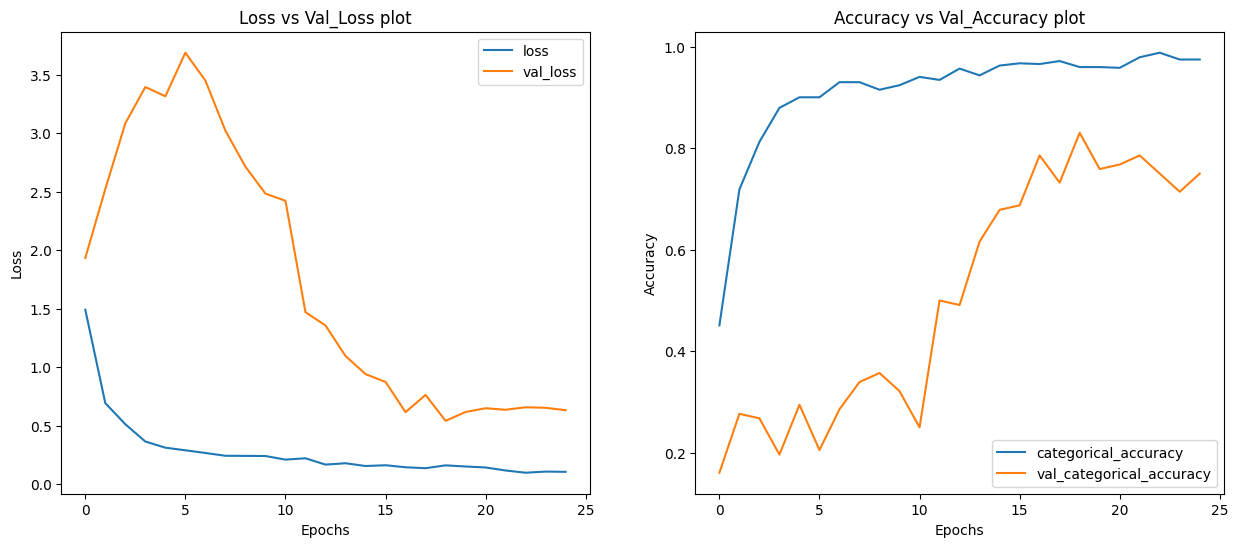

In [15]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model2',ip_img_size=(120,120))

### Model 3

Trying to add more number of layers

In [7]:
model = Sequential()
model.add(Conv3D(16, 3, padding='same',input_shape=(15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(16, 3, padding='same',input_shape=(15,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(5,activation='softmax'))

In [8]:
model=compile_(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                        

In [9]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model3',ip_img_size=(120,120),batch_size=16)

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (120, 120)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad' defined at (most recent call last):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\126785359.py", line 1, in <module>
      Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model3',ip_img_size=(120,120),batch_size=16)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 171, in train_model
      [history,model_path] = fit_model(model,epoch,train_doc,val_doc,batch_size=batch_size,name=name,min_lr=min_lr,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 77, in fit_model
      return [model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad'
OOM when allocating tensor with shape[16,16,15,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3298]

<b>The Model with batch size 16 is giving OOM and hence lets try with batch size 8

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (120, 120)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 8
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 83
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9693 - categorical_accuracy: 0.2892Source path =  Project_data\val ; batch size = 8

Epoch 1: saving model to Model3_2023-01-0210_56_52.749492\Model3-epoch_00001-loss_1.96932-cat_acc_0.28916-val_loss_2.04943-val_acc_0.18269.h5
83/83 [==============================] -

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.969316              0.289157  2.049428                  0.182692   
2      1.676327              0.371988  3.267842                  0.201923   
3      1.518633              0.438253  4.289061                  0.221154   
4      1.417751              0.465361  4.584065                  0.298077   
5      1.318396              0.500000  5.055192                  0.250000   
6      1.391173              0.493976  4.714823                  0.278846   
7      1.309419              0.518072  4.181714                  0.298077   
8      1.203577              0.564759  3.519493                  0.278846   
9      1.264086              0.519578  3.338060                  0.307692   
10     1.270440              0.522590  3.021010                  0.278846   
11     1.087025              0.557229  3.021283                  0.269231   
12     1.140126              0.542169  3.009936                  0.278846   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00001          0.106464  
2      0.00001          0.170065  
3      0.00001          0.217099  
4      0.00001          0.167285  
5      0.00001          0.250000  
6      0.00001          0.215130  
7      0.00001          0.219995  
8      0.00001          0.285913  
9      0.00001          0.211886  
10     0.00001          0.243744  
11     0.00001          0.287998  
12     0.00001          0.263323

<span style='color:red'>**This Model has maximum Validation Accuracy less than 70% and is recomended not to use**</span>

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
9      1.264086              0.519578   3.33806                  0.307692   

            lr  Acc_val-acc_diff  
Epoch                             
9      0.00001          0.211886

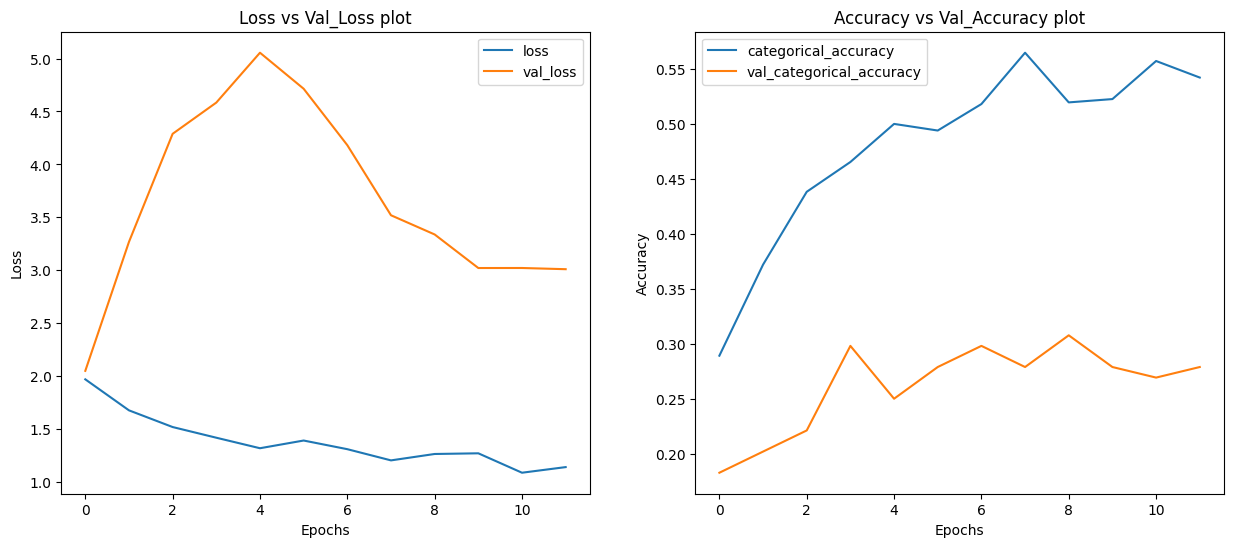

In [18]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,name='Model3',ip_img_size=(120,120),batch_size=8)


### <center>Results</center>
<b>Model Name - Model3<br>
Model has overfitted with low accuracy<br>
Best result - Epoch 9<br>
Categorical Accuracy - 0.519578<br>
Validation Accuracy - 0.307692<br>


### Model 4

Now from data set we could see that the most important information is present in frames from 11 and 20 so adding more images from these frames
making image index as [0, 2, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 28]

In [22]:
model = Sequential()
model.add(Conv3D(16, 3, padding='same',input_shape=(19,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [23]:
model = compile_(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 19, 100, 100, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 19, 100, 100, 16)  0         
                                                                 
 batch_normalization_28 (Bat  (None, 19, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 9, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 9, 50, 50, 32)     13856     
                                                                 
 activation_21 (Activation)  (None, 9, 50, 50, 32)    

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (100, 100)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 8
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 28] having length 19
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 83
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 2.0350 - categorical_accuracy: 0.3027Source path =  Project_data\val ; batch size = 8

Epoch 1: saving model to Model4_2023-01-0212_02_08.559778\Model4-epoch_00001-loss_2.03500-cat_acc_0.30271-val_loss_1.96526-val_acc_0.12500.h5
83/83 [=================

83/83 [==============================] - 82s 994ms/step - loss: 0.7943 - categorical_accuracy: 0.6958 - val_loss: 0.6540 - val_categorical_accuracy: 0.7404 - lr: 1.0000e-05
Epoch 19/25
83/83 [==============================] - ETA: 0s - loss: 0.8024 - categorical_accuracy: 0.6867
Epoch 19: saving model to Model4_2023-01-0212_02_08.559778\Model4-epoch_00019-loss_0.80238-cat_acc_0.68675-val_loss_0.81841-val_acc_0.73077.h5
83/83 [==============================] - 79s 966ms/step - loss: 0.8024 - categorical_accuracy: 0.6867 - val_loss: 0.8184 - val_categorical_accuracy: 0.7308 - lr: 1.0000e-05
Epoch 20/25
83/83 [==============================] - ETA: 0s - loss: 0.7419 - categorical_accuracy: 0.7154
Epoch 20: saving model to Model4_2023-01-0212_02_08.559778\Model4-epoch_00020-loss_0.74187-cat_acc_0.71536-val_loss_0.83486-val_acc_0.74038.h5
83/83 [==============================] - 80s 975ms/step - loss: 0.7419 - categorical_accuracy: 0.7154 - val_loss: 0.8349 - val_categorical_accuracy: 0.740

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      2.034997              0.302711  1.965265                  0.125000   
2      1.673018              0.393072  2.588996                  0.144231   
3      1.415234              0.462349  2.910944                  0.182692   
4      1.332371              0.504518  2.564750                  0.259615   
5      1.282459              0.533133  1.889733                  0.317308   
6      1.162375              0.527108  1.644614                  0.384615   
7      1.154240              0.572289  1.139760                  0.605769   
8      1.057807              0.611446  0.919025                  0.692308   
9      1.042067              0.609940  1.123230                  0.625000   
10     1.026075              0.605422  1.059126                  0.673077   
11     0.950029              0.641566  0.822419                  0.769231   
12     0.955319              0.629518  0.911678                  0.692308   
13     0.950574              0.621988  0.884481                  0.701923   
14     0.898107              0.653614  0.875193                  0.692308   
15     0.882727              0.671687  0.846032                  0.682692   
16     0.832967              0.685241  0.882159                  0.682692   
17     0.835513              0.667169  0.888029                  0.740385   
18     0.794277              0.695783  0.653967                  0.740385   
19     0.802385              0.686747  0.818408                  0.730769   
20     0.741871              0.715361  0.834863                  0.740385   
21     0.746681              0.698795  0.691396                  0.759615   
22     0.691439              0.745482  0.773122                  0.721154   
23     0.685685              0.743976  0.767856                  0.721154   
24     0.683819              0.739458  0.728546                  0.740385   
25     0.665023              0.746988  0.716743                  0.759615   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00001          0.177711  
2      0.00001          0.248842  
3      0.00001          0.279657  
4      0.00001          0.244903  
5      0.00001          0.215825  
6      0.00001          0.142493  
7      0.00001          0.033480  
8      0.00001          0.080862  
9      0.00001          0.015060  
10     0.00001          0.067655  
11     0.00001          0.127665  
12     0.00001          0.062790  
13     0.00001          0.079935  
14     0.00001          0.038693  
15     0.00001          0.011006  
16     0.00001          0.002549  
17     0.00001          0.073216  
18     0.00001          0.044602  
19     0.00001          0.044022  
20     0.00001          0.025023  
21     0.00001          0.060820  
22     0.00001          0.024328  
23     0.00001          0.022822  
24     0.00001          0.000927  
25     0.00001          0.012627

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
24     0.683819              0.739458  0.728546                  0.740385   

            lr  Acc_val-acc_diff  
Epoch                             
24     0.00001          0.000927

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
11     0.950029              0.641566  0.822419                  0.769231   

            lr  Acc_val-acc_diff  
Epoch                             
11     0.00001          0.127665

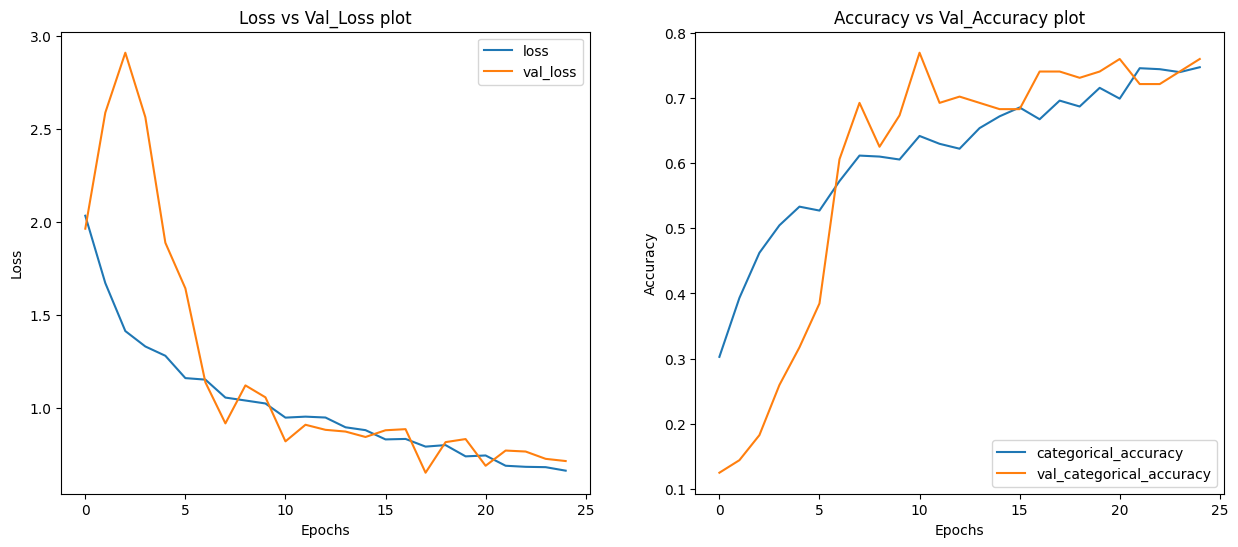

In [24]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model4',ip_img_size=(100,100),batch_size=8,
                        img_idx=[0, 2, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 28])

### Model 5

Let us try to reduce the layers and number of parameters

In [25]:
model = Sequential()
model.add(Conv3D(16, 3, padding='same',input_shape=(16,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#8,50,50,16

model.add(Conv3D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#4,25,25,32

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#2,12,12,64

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#1,6,6,128

model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [26]:
model = compile_(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_34 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_25 (Activation)  (None, 8, 50, 50, 32)    

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (100, 100)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29] having length 16
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.8970 - categorical_accuracy: 0.3140Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model5_2023-01-0212_43_13.221316\Model5-epoch_00001-loss_1.89697-cat_acc_0.31399-val_loss_1.93580-val_acc_0.16964.h5
42/42 [==========================

42/42 [==============================] - 71s 2s/step - loss: 0.3875 - categorical_accuracy: 0.8899 - val_loss: 0.9177 - val_categorical_accuracy: 0.6339 - lr: 1.0000e-05
Epoch 19/25
42/42 [==============================] - ETA: 0s - loss: 0.4080 - categorical_accuracy: 0.8780
Epoch 19: saving model to Model5_2023-01-0212_43_13.221316\Model5-epoch_00019-loss_0.40801-cat_acc_0.87798-val_loss_0.88887-val_acc_0.70536.h5
42/42 [==============================] - 71s 2s/step - loss: 0.4080 - categorical_accuracy: 0.8780 - val_loss: 0.8889 - val_categorical_accuracy: 0.7054 - lr: 1.0000e-05
Epoch 20/25
42/42 [==============================] - ETA: 0s - loss: 0.3982 - categorical_accuracy: 0.8824
Epoch 20: saving model to Model5_2023-01-0212_43_13.221316\Model5-epoch_00020-loss_0.39815-cat_acc_0.88244-val_loss_0.81188-val_acc_0.68750.h5
42/42 [==============================] - 70s 2s/step - loss: 0.3982 - categorical_accuracy: 0.8824 - val_loss: 0.8119 - val_categorical_accuracy: 0.6875 - lr: 1

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.896972              0.313988  1.935799                  0.169643   
2      1.263358              0.482143  2.398577                  0.142857   
3      1.084364              0.575893  2.943083                  0.169643   
4      0.977170              0.636905  3.291873                  0.151786   
5      0.866396              0.677083  3.302004                  0.187500   
6      0.774341              0.717262  3.549953                  0.169643   
7      0.723948              0.717262  2.886758                  0.258929   
8      0.663049              0.754464  3.024434                  0.187500   
9      0.579922              0.809524  2.489641                  0.232143   
10     0.573645              0.815476  2.450937                  0.214286   
11     0.583134              0.805060  1.869953                  0.294643   
12     0.502062              0.845238  1.717499                  0.303571   
13     0.517534              0.837798  1.380987                  0.482143   
14     0.488644              0.843750  1.239794                  0.473214   
15     0.445004              0.870536  1.147964                  0.508929   
16     0.462187              0.848214  1.018417                  0.580357   
17     0.402213              0.866071  1.052797                  0.526786   
18     0.387521              0.889881  0.917738                  0.633929   
19     0.408006              0.877976  0.888873                  0.705357   
20     0.398151              0.882440  0.811877                  0.687500   
21     0.362538              0.907738  0.871804                  0.678571   
22     0.363961              0.897321  0.897406                  0.669643   
23     0.342074              0.904762  0.775872                  0.705357   
24     0.337525              0.919643  0.790192                  0.705357   
25     0.336400              0.927083  0.792280                  0.696429   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00001          0.144345  
2      0.00001          0.339286  
3      0.00001          0.406250  
4      0.00001          0.485119  
5      0.00001          0.489583  
6      0.00001          0.547619  
7      0.00001          0.458333  
8      0.00001          0.566964  
9      0.00001          0.577381  
10     0.00001          0.601190  
11     0.00001          0.510417  
12     0.00001          0.541667  
13     0.00001          0.355655  
14     0.00001          0.370536  
15     0.00001          0.361607  
16     0.00001          0.267857  
17     0.00001          0.339286  
18     0.00001          0.255952  
19     0.00001          0.172619  
20     0.00001          0.194940  
21     0.00001          0.229167  
22     0.00001          0.227679  
23     0.00001          0.199405  
24     0.00001          0.214286  
25     0.00001          0.230655

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
19     0.408006              0.877976  0.888873                  0.705357   

            lr  Acc_val-acc_diff  
Epoch                             
19     0.00001          0.172619

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
19     0.408006              0.877976  0.888873                  0.705357   
23     0.342074              0.904762  0.775872                  0.705357   
24     0.337525              0.919643  0.790192                  0.705357   

            lr  Acc_val-acc_diff  
Epoch                             
19     0.00001          0.172619  
23     0.00001          0.199405  
24     0.00001          0.214286

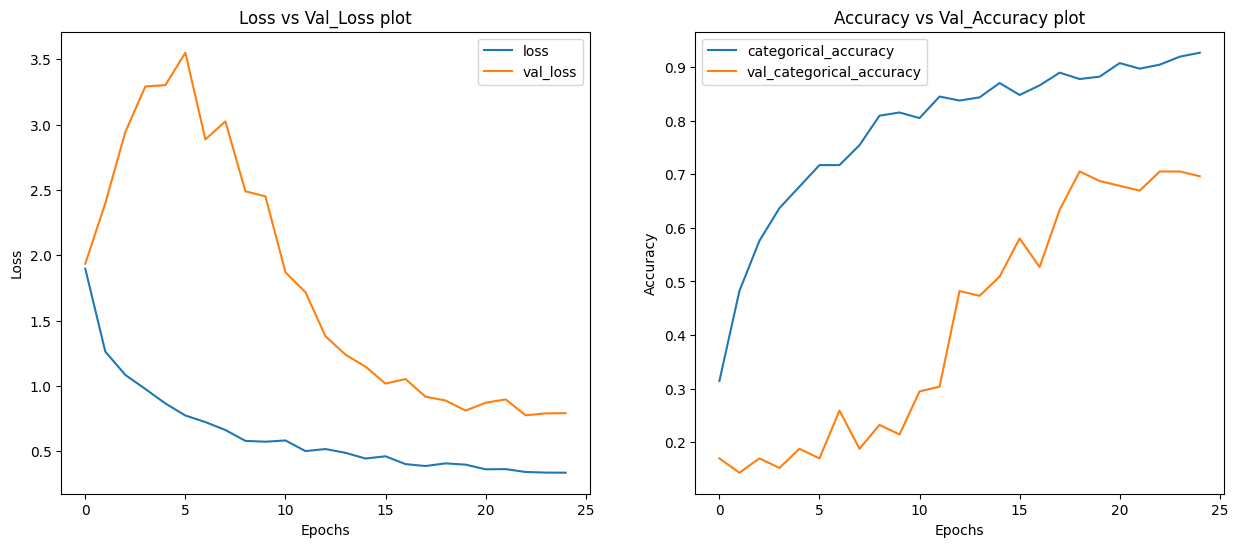

In [27]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model5',ip_img_size=(100,100),batch_size=16,
                        img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29],
                          lr_reduce_factor=0.1)

### Model 6

Reducing the parameters even less to make the model more generic and also making the image size as 80*80

In [9]:
model = Sequential()
model.add(Conv3D(16, 3,input_shape=(16,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#7,39,39,16

model.add(Conv3D(32, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
#5,37,37,32

model.add(Conv3D(64, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#2,17,17,64

model.add(Conv3D(32, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#1,8,8,32

model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [10]:
model = compile_(model,optimiser=optimizers.SGD(learning_rate=0.1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 78, 78, 16)    1312      
                                                                 
 activation (Activation)     (None, 14, 78, 78, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 14, 78, 78, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 39, 39, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 37, 37, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 5, 37, 37, 32)     0

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29] having length 16
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.5431 - categorical_accuracy: 0.4167Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model6_2023-01-0214_01_56.350717\Model6-epoch_00001-loss_1.54309-cat_acc_0.41667-val_loss_48.33849-val_acc_0.19643.h5
42/42 [===========================

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy   val_loss  val_categorical_accuracy  \
Epoch                                                                        
1      1.543089              0.416667  48.338493                  0.196429   
2      1.128402              0.538690  15.720878                  0.232143   
3      0.931926              0.636905   5.464100                  0.258929   
4      0.748771              0.721726   2.011348                  0.375000   
5      0.631499              0.755952   0.933563                  0.598214   
6      0.603143              0.778274   1.131800                  0.642857   
7      0.481158              0.816964   1.656936                  0.553571   
8      0.422599              0.830357   0.940452                  0.714286   
9      0.283318              0.903274   0.932130                  0.687500   
10     0.260847              0.915179   1.020056                  0.616071   
11     0.262742              0.906250   0.772023                  0.723214   
12     0.243827              0.918155   0.871704                  0.723214   
13     0.214290              0.927083   0.915942                  0.732143   
14     0.188044              0.934524   0.843209                  0.776786   
15     0.239315              0.922619   0.863074                  0.750000   
16     0.187536              0.938988   0.946288                  0.750000   
17     0.165251              0.962798   0.974046                  0.714286   
18     0.196418              0.931548   1.167811                  0.696429   
19     0.205474              0.928571   0.665978                  0.741071   
20     0.197495              0.943452   1.113179                  0.678571   
21     0.177843              0.936012   0.913166                  0.750000   

           lr  Acc_val-acc_diff  
Epoch                            
1      0.1000          0.220238  
2      0.1000          0.306548  
3      0.1000          0.377976  
4      0.1000          0.346726  
5      0.1000          0.157738  
6      0.1000          0.135417  
7      0.1000          0.263393  
8      0.1000          0.116071  
9      0.0100          0.215774  
10     0.0100          0.299107  
11     0.0100          0.183036  
12     0.0100          0.194941  
13     0.0100          0.194940  
14     0.0100          0.157738  
15     0.0010          0.172619  
16     0.0010          0.188988  
17     0.0010          0.248512  
18     0.0001          0.235119  
19     0.0001          0.187500  
20     0.0001          0.264881  
21     0.0001          0.186012

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
8      0.422599              0.830357  0.940452                  0.714286   

        lr  Acc_val-acc_diff  
Epoch                         
8      0.1          0.116071

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
14     0.188044              0.934524  0.843209                  0.776786   

         lr  Acc_val-acc_diff  
Epoch                          
14     0.01          0.157738

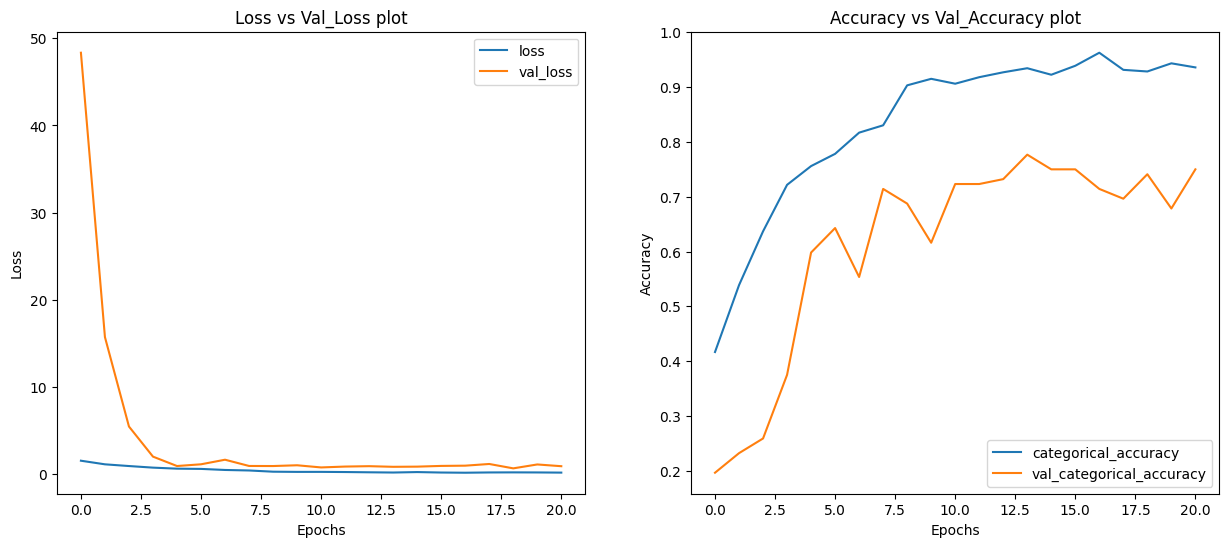

In [11]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model6',ip_img_size=(80,80),batch_size=16,
                        img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29],
                          lr_reduce_factor=0.1)

#### Model 7

Trying with all 30 frames with even less number of parameters, less than 200K parameters

In [12]:
model = Sequential()
model.add(Conv3D(16, 3,input_shape=(30,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#14,39,39,16

model.add(Conv3D(32, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
#14,39,39,32

model.add(Conv3D(64, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#6,19,19,64

model.add(Conv3D(32, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#3,9,9,32

model.add(Conv3D(32, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#1,4,4,32

model.add(Flatten())
model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [13]:
model = compile_(model,optimiser=optimizers.SGD(learning_rate=0.1))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 28, 78, 78, 16)    1312      
                                                                 
 activation_4 (Activation)   (None, 28, 78, 78, 16)    0         
                                                                 
 batch_normalization_6 (Batc  (None, 28, 78, 78, 16)   64        
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 14, 39, 39, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 14, 39, 39, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 14, 39, 39, 32)   

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] having length 30
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.5652 - categorical_accuracy: 0.3586Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model7_2023-01-0214_26_23.061933\Model7-epoch_00001-loss_1.56524-cat_acc_0.35863-val_loss_43.12922-va

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy   val_loss  val_categorical_accuracy  \
Epoch                                                                        
1      1.565242              0.358631  43.129223                  0.241071   
2      0.993615              0.601190  15.681783                  0.232143   
3      0.773580              0.694940   2.638351                  0.473214   
4      0.590956              0.779762   1.128882                  0.526786   
5      0.482293              0.813988   0.847743                  0.714286   
6      0.385894              0.845238   0.838826                  0.669643   
7      0.292361              0.897321   0.627727                  0.803571   
8      0.222001              0.915179   0.784298                  0.723214   
9      0.242167              0.915179   1.791984                  0.508929   
10     0.171723              0.947917   0.724825                  0.767857   
11     0.142755              0.959821   0.859492                  0.767857   
12     0.098472              0.968750   0.872119                  0.758929   
13     0.081340              0.980655   0.664517                  0.803571   
14     0.074173              0.980655   0.564323                  0.839286   
15     0.079263              0.979167   0.470669                  0.848214   
16     0.066959              0.986607   0.477109                  0.848214   
17     0.068688              0.985119   0.414056                  0.857143   
18     0.080839              0.983631   0.491049                  0.839286   
19     0.083242              0.979167   0.519865                  0.812500   
20     0.085182              0.980655   0.406950                  0.803571   

          lr  Acc_val-acc_diff  
Epoch                           
1      0.100          0.117560  
2      0.100          0.369048  
3      0.100          0.221726  
4      0.100          0.252976  
5      0.100          0.099702  
6      0.100          0.175595  
7      0.100          0.093750  
8      0.100          0.191964  
9      0.100          0.406250  
10     0.100          0.180060  
11     0.010          0.191964  
12     0.010          0.209821  
13     0.010          0.177083  
14     0.001          0.141369  
15     0.001          0.130952  
16     0.001          0.138393  
17     0.001          0.127976  
18     0.001          0.144345  
19     0.001          0.166667  
20     0.001          0.177083

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
7      0.292361              0.897321  0.627727                  0.803571   

        lr  Acc_val-acc_diff  
Epoch                         
7      0.1           0.09375

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
17     0.068688              0.985119  0.414056                  0.857143   

          lr  Acc_val-acc_diff  
Epoch                           
17     0.001          0.127976

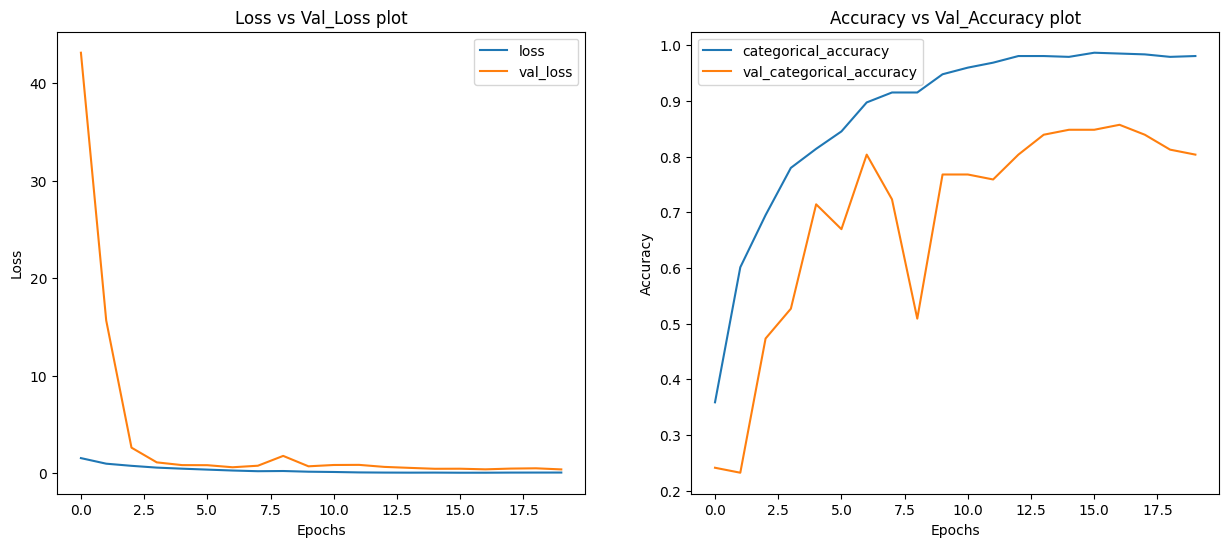

In [14]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model7',ip_img_size=(80,80),batch_size=16,
                        img_idx=[i for i in range(0,30)],
                          lr_reduce_factor=0.1)

### Model 8

In [15]:
# Model 6 gave good results on 13th epoch so using the same hyperparameters except now using all 120*120 the images in the input


model = Sequential()
model.add(Conv3D(16, 3,input_shape=(16,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#7,59,59,16

model.add(Conv3D(32, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
#5,57,57,32

model.add(Conv3D(64, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#2,28,28,64

model.add(Conv3D(32, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#1,14,14,32

model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [16]:
model = compile_(model,optimiser=optimizers.SGD(learning_rate=0.1))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 14, 118, 118, 16)  1312      
                                                                 
 activation_9 (Activation)   (None, 14, 118, 118, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 14, 118, 118, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 7, 59, 59, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 57, 57, 32)     13856     
                                                                 
 activation_10 (Activation)  (None, 5, 57, 57, 32)    

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (120, 120)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29] having length 16
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.6351 - categorical_accuracy: 0.3795Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model8_2023-01-0215_10_53.441696\Model8-epoch_00001-loss_1.63506-cat_acc_0.37946-val_loss_49.64711-val_acc_0.19643.h5
42/42 [=========================

42/42 [==============================] - 74s 2s/step - loss: 0.1276 - categorical_accuracy: 0.9524 - val_loss: 0.6763 - val_categorical_accuracy: 0.6964 - lr: 1.0000e-03
Epoch 19/25
42/42 [==============================] - ETA: 0s - loss: 0.1565 - categorical_accuracy: 0.9509
Epoch 19: saving model to Model8_2023-01-0215_10_53.441696\Model8-epoch_00019-loss_0.15648-cat_acc_0.95089-val_loss_0.66570-val_acc_0.69643.h5
42/42 [==============================] - 74s 2s/step - loss: 0.1565 - categorical_accuracy: 0.9509 - val_loss: 0.6657 - val_categorical_accuracy: 0.6964 - lr: 1.0000e-03
 
Since the Accuracy was not increasing for the past 4 epochs, Early stopping is in action to stop the training by 19 instead of 25
 


<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy   val_loss  val_categorical_accuracy  \
Epoch                                                                        
1      1.635063              0.379464  49.647106                  0.196429   
2      1.161604              0.535714   6.994141                  0.276786   
3      1.006799              0.595238   2.410383                  0.321429   
4      0.843352              0.666667   1.909533                  0.482143   
5      0.769405              0.688988   1.016409                  0.571429   
6      0.750753              0.723214   1.167937                  0.544643   
7      0.585794              0.781250   1.050262                  0.642857   
8      0.512113              0.805060   0.931368                  0.669643   
9      0.410369              0.842262   1.217582                  0.562500   
10     0.415541              0.860119   0.959814                  0.633929   
11     0.399384              0.836310   0.784260                  0.678571   
12     0.259179              0.906250   1.613476                  0.553571   
13     0.242254              0.922619   1.336823                  0.598214   
14     0.291343              0.906250   0.953694                  0.642857   
15     0.140173              0.965774   0.876800                  0.714286   
16     0.122120              0.956845   0.932804                  0.696429   
17     0.175971              0.930060   0.866952                  0.678571   
18     0.127557              0.952381   0.676263                  0.696429   
19     0.156484              0.950893   0.665703                  0.696429   

          lr  Acc_val-acc_diff  
Epoch                           
1      0.100          0.183036  
2      0.100          0.258929  
3      0.100          0.273810  
4      0.100          0.184524  
5      0.100          0.117559  
6      0.100          0.178571  
7      0.100          0.138393  
8      0.100          0.135417  
9      0.100          0.279762  
10     0.100          0.226190  
11     0.100          0.157738  
12     0.100          0.352679  
13     0.100          0.324405  
14     0.100          0.263393  
15     0.010          0.251488  
16     0.010          0.260417  
17     0.010          0.251488  
18     0.001          0.255952  
19     0.001          0.254464

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
15     0.140173              0.965774    0.8768                  0.714286   

         lr  Acc_val-acc_diff  
Epoch                          
15     0.01          0.251488

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
15     0.140173              0.965774    0.8768                  0.714286   

         lr  Acc_val-acc_diff  
Epoch                          
15     0.01          0.251488

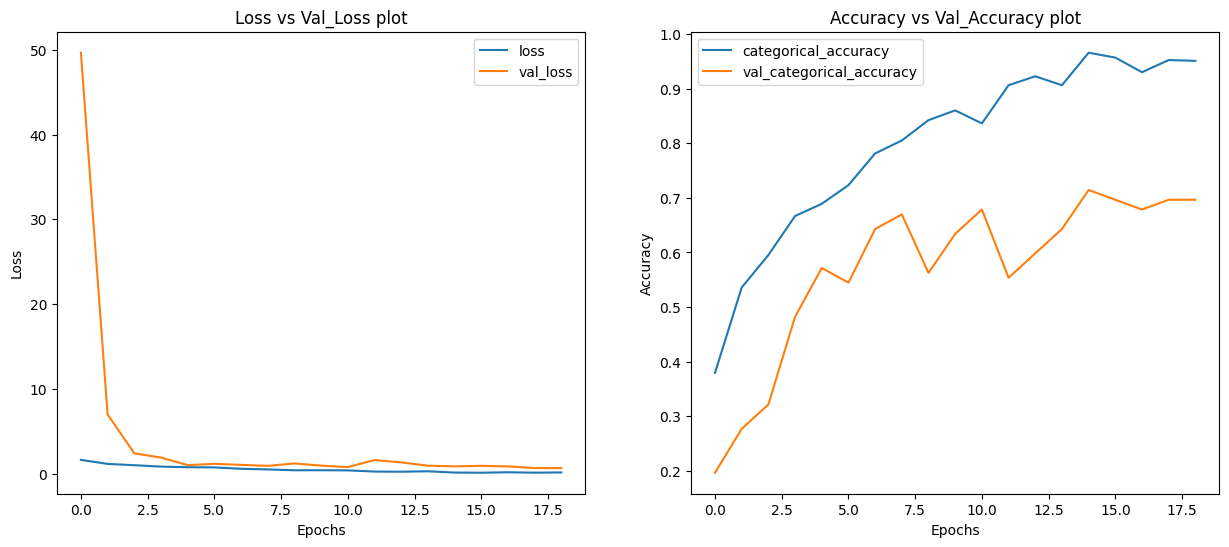

In [17]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model8',ip_img_size=(120,120),batch_size=16,
                        img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29],
                          lr_reduce_factor=0.1)

## Trying with RNN based models

### Model 9

In [18]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.2))

model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [19]:
model = compile_(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 50, 50, 32)  

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (100, 100)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 15
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 45
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 15
Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 1.3227 - categorical_accuracy: 0.4681Source path =  Project_data\val ; batch size = 15

Epoch 1: saving model to Model9_2023-01-0215_38_07.294454\Model9-epoch_00001-loss_1.32269-cat_acc_0.46815-val_loss_1.85695-val_acc_0.23810.h5
45/45 [==============================

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.322694              0.468148  1.856949                  0.238095   
2      0.959869              0.626667  2.211368                  0.238095   
3      0.798399              0.685926  1.944426                  0.190476   
4      0.708520              0.742222  2.982169                  0.180952   
5      0.421719              0.866667  2.574058                  0.266667   
6      0.265216              0.920000  2.864446                  0.209524   
7      0.231264              0.931852  2.681544                  0.257143   
8      0.177250              0.961481  2.616495                  0.257143   
9      0.143884              0.964444  2.573875                  0.323810   
10     0.147989              0.961481  1.907867                  0.419048   
11     0.140131              0.977778  1.353525                  0.542857   
12     0.112890              0.977778  1.201585                  0.619048   
13     0.116368              0.974815  1.025101                  0.685714   
14     0.112413              0.976296  0.700855                  0.752381   
15     0.111383              0.980741  0.484407                  0.857143   
16     0.108009              0.973333  0.514964                  0.847619   
17     0.102448              0.985185  0.643043                  0.819048   
18     0.118407              0.974815  0.534949                  0.857143   
19     0.113974              0.971852  0.490986                  0.876190   
20     0.113236              0.973333  0.395013                  0.885714   
21     0.105511              0.985185  0.558407                  0.828571   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.230053  
2      0.00100          0.388571  
3      0.00100          0.495450  
4      0.00100          0.561270  
5      0.00020          0.600000  
6      0.00020          0.710476  
7      0.00020          0.674709  
8      0.00004          0.704339  
9      0.00004          0.640635  
10     0.00004          0.542434  
11     0.00001          0.434921  
12     0.00001          0.358730  
13     0.00001          0.289101  
14     0.00001          0.223915  
15     0.00001          0.123598  
16     0.00001          0.125714  
17     0.00001          0.166138  
18     0.00001          0.117672  
19     0.00001          0.095661  
20     0.00001          0.087619  
21     0.00001          0.156614

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
20     0.113236              0.973333  0.395013                  0.885714   

            lr  Acc_val-acc_diff  
Epoch                             
20     0.00001          0.087619

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
20     0.113236              0.973333  0.395013                  0.885714   

            lr  Acc_val-acc_diff  
Epoch                             
20     0.00001          0.087619

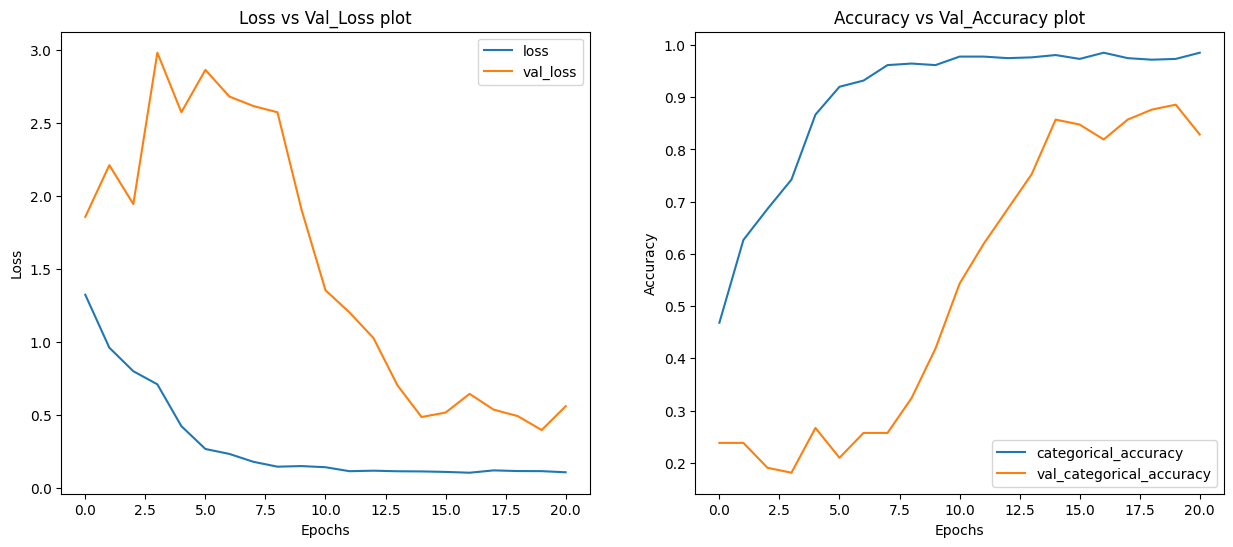

In [20]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model9',ip_img_size=(100,100),batch_size=15,
                          lr_reduce_factor=0.2)

### Model 10

In [7]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3),padding='same', activation='relu'),input_shape=(30,85,85,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#42
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#21
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#10
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#5
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#2
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#1

model.add(TimeDistributed(Flatten()))

model.add(LSTM(40))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [8]:
model = compile_(model,optimiser=optimizers.Adam(learning_rate=0.01))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 85, 85, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 85, 85, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 42, 42, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 42, 42, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 42, 42, 32)   1

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (85, 85)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] having length 30
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.4405 - categorical_accuracy: 0.3289Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model10_2023-01-0217_48_10.770162\Model10-epoch_00001-loss_1.44053-cat_acc_0.32887-val_loss_1.99532-v

42/42 [==============================] - 118s 3s/step - loss: 0.3004 - categorical_accuracy: 0.8973 - val_loss: 1.0901 - val_categorical_accuracy: 0.6518 - lr: 0.0020
Epoch 19/25
42/42 [==============================] - ETA: 0s - loss: 0.2714 - categorical_accuracy: 0.9092
Epoch 19: saving model to Model10_2023-01-0217_48_10.770162\Model10-epoch_00019-loss_0.27137-cat_acc_0.90923-val_loss_2.05661-val_acc_0.47321.h5
42/42 [==============================] - 123s 3s/step - loss: 0.2714 - categorical_accuracy: 0.9092 - val_loss: 2.0566 - val_categorical_accuracy: 0.4732 - lr: 0.0020
Epoch 20/25
42/42 [==============================] - ETA: 0s - loss: 0.2433 - categorical_accuracy: 0.9196
Epoch 20: saving model to Model10_2023-01-0217_48_10.770162\Model10-epoch_00020-loss_0.24335-cat_acc_0.91964-val_loss_1.27546-val_acc_0.56250.h5

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
42/42 [==============================] - 121s 3s/step - loss: 0.2433 - categorical_a

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.440532              0.328869  1.995316                  0.214286   
2      1.251633              0.430060  2.425925                  0.205357   
3      1.232259              0.449405  2.714238                  0.196429   
4      1.156829              0.474702  2.725613                  0.232143   
5      1.077795              0.559524  1.994959                  0.375000   
6      0.961050              0.592262  1.664200                  0.437500   
7      0.858687              0.657738  1.321714                  0.437500   
8      0.774867              0.712798  1.209784                  0.526786   
9      0.713250              0.730655  1.136132                  0.517857   
10     0.640620              0.773810  1.312647                  0.544643   
11     0.667619              0.745536  1.126628                  0.616071   
12     0.592994              0.784226  1.109108                  0.562500   
13     0.508523              0.828869  1.495991                  0.562500   
14     0.470905              0.839286  0.951739                  0.723214   
15     0.419675              0.869048  1.131822                  0.642857   
16     0.351804              0.894345  1.194019                  0.669643   
17     0.262054              0.910714  0.833863                  0.732143   
18     0.300423              0.897321  1.090123                  0.651786   
19     0.271366              0.909226  2.056614                  0.473214   
20     0.243347              0.919643  1.275457                  0.562500   
21     0.171675              0.956845  0.673687                  0.750000   
22     0.137586              0.962798  0.520344                  0.812500   
23     0.141116              0.965774  0.658603                  0.794643   
24     0.085386              0.980655  0.781627                  0.821429   
25     0.092243              0.979167  0.683621                  0.830357   

           lr  Acc_val-acc_diff  
Epoch                            
1      0.0100          0.114583  
2      0.0100          0.224702  
3      0.0100          0.252976  
4      0.0100          0.242560  
5      0.0020          0.184524  
6      0.0020          0.154762  
7      0.0020          0.220238  
8      0.0020          0.186012  
9      0.0020          0.212798  
10     0.0020          0.229167  
11     0.0020          0.129464  
12     0.0020          0.221726  
13     0.0020          0.266369  
14     0.0020          0.116071  
15     0.0020          0.226191  
16     0.0020          0.224702  
17     0.0020          0.178571  
18     0.0020          0.245536  
19     0.0020          0.436012  
20     0.0020          0.357143  
21     0.0004          0.206845  
22     0.0004          0.150298  
23     0.0004          0.171131  
24     0.0004          0.159226  
25     0.0004          0.148810

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
14     0.470905              0.839286  0.951739                  0.723214   

          lr  Acc_val-acc_diff  
Epoch                           
14     0.002          0.116071

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
25     0.092243              0.979167  0.683621                  0.830357   

           lr  Acc_val-acc_diff  
Epoch                            
25     0.0004           0.14881

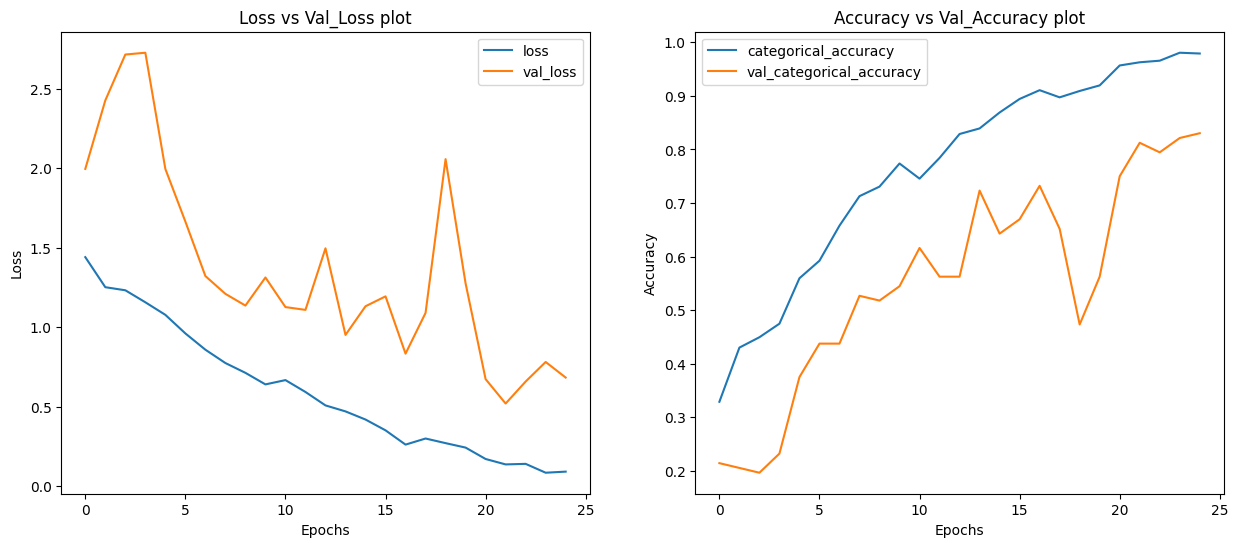

In [9]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model10',ip_img_size=(85,85),batch_size=16,
                          img_idx=[i for i in range(0,30)],
                          lr_reduce_factor=0.2)

### Model 11

In [7]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3),padding='same', activation='relu'),input_shape=(30,85,85,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#42
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#21
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#10
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#5
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#2
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#1

model.add(TimeDistributed(Flatten()))

model.add(GRU(40))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [8]:
model = compile_(model,optimiser=optimizers.Adam(learning_rate=0.0001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 85, 85, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 85, 85, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 42, 42, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 42, 42, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 42, 42, 32)   1

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (85, 85)
     3. Learning rate reduction factor: 0.25
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] having length 30
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.3668 - categorical_accuracy: 0.4464Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model11_2023-01-0218_41_27.798239\Model11-epoch_00001-loss_1.36678-cat_acc_0.44643-val_loss_1.62400-

 
Since the Accuracy was not increasing for the past 4 epochs, Early stopping is in action to stop the training by 17 instead of 25
 


<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.366784              0.446429  1.623997                  0.232143   
2      0.717861              0.767857  1.762671                  0.223214   
3      0.455224              0.885417  1.854799                  0.232143   
4      0.301563              0.952381  1.964908                  0.214286   
5      0.206914              0.982143  2.154252                  0.223214   
6      0.200070              0.988095  2.057452                  0.303571   
7      0.173800              0.986607  2.167181                  0.294643   
8      0.162051              0.992560  2.157186                  0.312500   
9      0.159668              0.991071  1.979025                  0.312500   
10     0.144776              0.997024  1.820362                  0.348214   
11     0.142906              0.997024  1.625486                  0.366071   
12     0.144557              0.994048  1.519509                  0.428571   
13     0.129101              0.998512  1.211238                  0.508929   
14     0.116798              0.997024  1.018024                  0.607143   
15     0.125513              0.995536  0.868717                  0.705357   
16     0.117479              0.995536  0.950700                  0.714286   
17     0.117766              0.997024  0.817390                  0.776786   

             lr  Acc_val-acc_diff  
Epoch                              
1      0.000100          0.214286  
2      0.000100          0.544643  
3      0.000100          0.653274  
4      0.000100          0.738095  
5      0.000025          0.758929  
6      0.000025          0.684524  
7      0.000025          0.691964  
8      0.000010          0.680060  
9      0.000010          0.678571  
10     0.000010          0.648810  
11     0.000010          0.630952  
12     0.000010          0.565476  
13     0.000010          0.489583  
14     0.000010          0.389881  
15     0.000010          0.290179  
16     0.000010          0.281250  
17     0.000010          0.220238

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
17     0.117766              0.997024   0.81739                  0.776786   

            lr  Acc_val-acc_diff  
Epoch                             
17     0.00001          0.220238

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
17     0.117766              0.997024   0.81739                  0.776786   

            lr  Acc_val-acc_diff  
Epoch                             
17     0.00001          0.220238

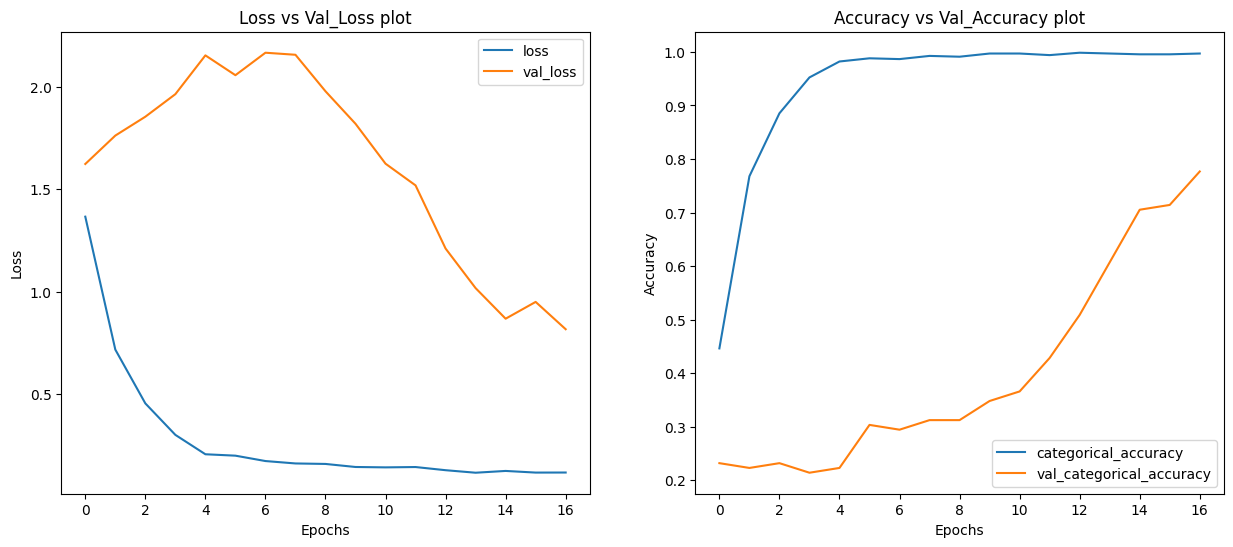

In [9]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model11',ip_img_size=(85,85),batch_size=16,
                          img_idx=[i for i in range(0,30)],
                          lr_reduce_factor=0.25)

### Model 12

In [7]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3),padding='same', activation='relu'),input_shape=(30,85,85,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#42
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#21
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#10
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#5
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#2
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#1

model.add(TimeDistributed(Flatten()))

model.add(LSTM(40))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [8]:
model = compile_(model,optimiser=optimizers.SGD(learning_rate=0.01))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 85, 85, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 85, 85, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 42, 42, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 42, 42, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 42, 42, 32)   1

Hyperparameter values-
     1. Epoch: 30
     2. Crop size of Frame: (85, 85)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] having length 30
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.3982 - categorical_accuracy: 0.4167Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model12_2023-01-0220_11_28.863049\Model12-epoch_00001-loss_1.39816-cat_acc_0.41667-val_loss_1.68828-v

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.398159              0.416667  1.688283                  0.187500   
2      1.086140              0.593750  1.791072                  0.205357   
3      0.894967              0.686012  1.768874                  0.205357   
4      0.701583              0.758929  1.806168                  0.285714   
5      0.484029              0.876488  1.834757                  0.285714   
6      0.468121              0.879464  1.686914                  0.366071   
7      0.411499              0.907738  1.725535                  0.321429   
8      0.392074              0.915179  1.614253                  0.428571   
9      0.371994              0.922619  1.409799                  0.455357   
10     0.358340              0.928571  1.325714                  0.500000   
11     0.329027              0.943452  1.064920                  0.562500   
12     0.311060              0.936012  1.145215                  0.535714   
13     0.297464              0.958333  0.934123                  0.696429   
14     0.275544              0.947917  0.805200                  0.723214   
15     0.278575              0.955357  0.749545                  0.723214   
16     0.257299              0.970238  0.842665                  0.687500   
17     0.243855              0.976190  0.763733                  0.750000   
18     0.234192              0.971726  0.757756                  0.696429   
19     0.213709              0.988095  0.732490                  0.732143   
20     0.225305              0.973214  0.807925                  0.705357   
21     0.217900              0.974702  0.745472                  0.723214   
22     0.226612              0.967262  0.701717                  0.741071   
23     0.223480              0.973214  0.748761                  0.705357   

           lr  Acc_val-acc_diff  
Epoch                            
1      0.0100          0.229167  
2      0.0100          0.388393  
3      0.0100          0.480655  
4      0.0100          0.473214  
5      0.0010          0.590774  
6      0.0010          0.513393  
7      0.0010          0.586310  
8      0.0010          0.486607  
9      0.0010          0.467262  
10     0.0010          0.428571  
11     0.0010          0.380952  
12     0.0010          0.400298  
13     0.0010          0.261905  
14     0.0010          0.224702  
15     0.0010          0.232143  
16     0.0010          0.282738  
17     0.0010          0.226190  
18     0.0010          0.275298  
19     0.0001          0.255952  
20     0.0001          0.267857  
21     0.0001          0.251488  
22     0.0001          0.226191  
23     0.0001          0.267857

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
14     0.275544              0.947917    0.8052                  0.723214   

          lr  Acc_val-acc_diff  
Epoch                           
14     0.001          0.224702

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
17     0.243855               0.97619  0.763733                      0.75   

          lr  Acc_val-acc_diff  
Epoch                           
17     0.001           0.22619

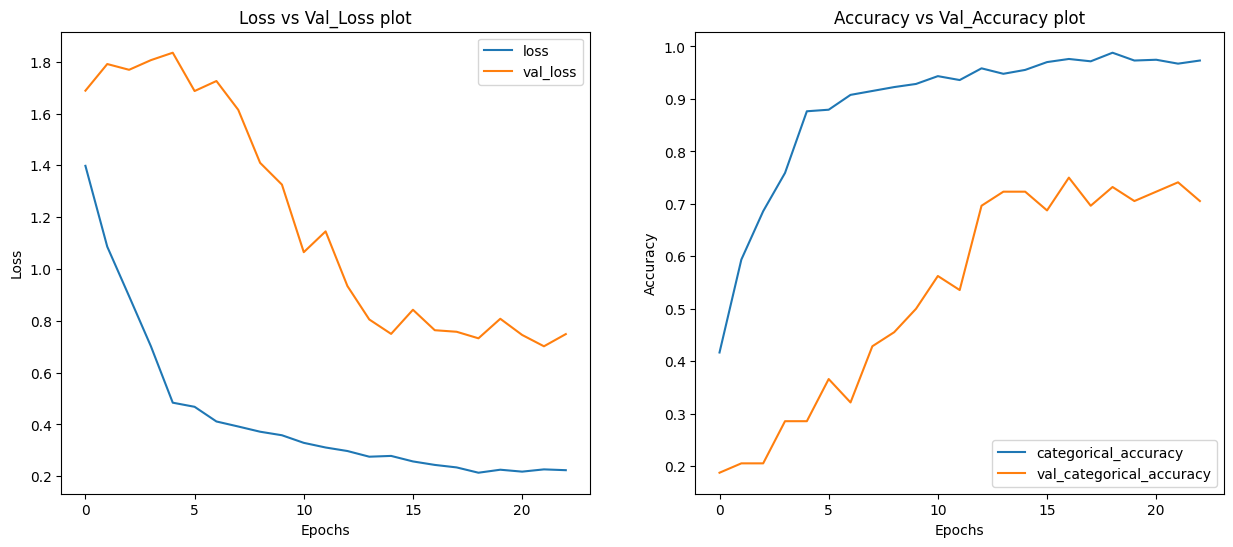

In [9]:
Model_history=train_model(model,epoch=30,train_doc=train_doc,val_doc=val_doc,
                           name='Model12',ip_img_size=(85,85),batch_size=16,
                          img_idx=[i for i in range(0,30)],
                          lr_reduce_factor=0.1)

### Model 13

In [7]:
# For the same model12 just changing the early stopping parameters and trying to train

In [8]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3),padding='same', activation='relu'),input_shape=(30,85,85,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#42
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#21
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#10
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#5
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#2
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#1

model.add(TimeDistributed(Flatten()))

model.add(LSTM(40))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

model = compile_(model,optimiser=optimizers.SGD(learning_rate=0.01))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 85, 85, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 85, 85, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 42, 42, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 42, 42, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 42, 42, 32)   1

Hyperparameter values-
     1. Epoch: 30
     2. Crop size of Frame: (85, 85)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] having length 30
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 5
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.3367 - categorical_accuracy: 0.4583Source path =  Project_data\val ; batch size = 16

Epoch 1: saving model to Model13_2023-01-0221_21_12.088106\Model13-epoch_00001-loss_1.33670-cat_acc_0.45833-val_loss_1.65971-v

Epoch 18/30
42/42 [==============================] - ETA: 0s - loss: 0.3217 - categorical_accuracy: 0.9509
Epoch 18: saving model to Model13_2023-01-0221_21_12.088106\Model13-epoch_00018-loss_0.32174-cat_acc_0.95089-val_loss_0.80534-val_acc_0.75893.h5
42/42 [==============================] - 118s 3s/step - loss: 0.3217 - categorical_accuracy: 0.9509 - val_loss: 0.8053 - val_categorical_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 19/30
42/42 [==============================] - ETA: 0s - loss: 0.3253 - categorical_accuracy: 0.9405
Epoch 19: saving model to Model13_2023-01-0221_21_12.088106\Model13-epoch_00019-loss_0.32530-cat_acc_0.94048-val_loss_0.80370-val_acc_0.76786.h5
42/42 [==============================] - 118s 3s/step - loss: 0.3253 - categorical_accuracy: 0.9405 - val_loss: 0.8037 - val_categorical_accuracy: 0.7679 - lr: 1.0000e-04
Epoch 20/30
42/42 [==============================] - ETA: 0s - loss: 0.3276 - categorical_accuracy: 0.9524
Epoch 20: saving model to Model13_2023-01-0221_

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.336696              0.458333  1.659714                  0.133929   
2      1.006755              0.619048  1.717829                  0.178571   
3      0.799289              0.712798  1.682662                  0.258929   
4      0.602654              0.790179  1.772040                  0.232143   
5      0.448867              0.867560  1.825867                  0.330357   
6      0.422560              0.892857  1.682371                  0.303571   
7      0.375001              0.924107  1.685417                  0.410714   
8      0.356943              0.931548  1.556990                  0.437500   
9      0.342950              0.934524  1.508518                  0.446429   
10     0.345721              0.933036  1.401045                  0.482143   
11     0.346770              0.941964  1.173867                  0.544643   
12     0.347621              0.930060  1.149711                  0.607143   
13     0.326261              0.944940  1.050977                  0.580357   
14     0.323549              0.941964  0.897826                  0.669643   
15     0.345680              0.927083  0.824548                  0.723214   
16     0.330965              0.934524  0.887139                  0.705357   
17     0.330605              0.931548  0.804291                  0.696429   
18     0.321744              0.950893  0.805340                  0.758929   
19     0.325296              0.940476  0.803699                  0.767857   
20     0.327580              0.952381  0.802755                  0.723214   
21     0.307596              0.937500  0.770303                  0.767857   
22     0.317771              0.941964  0.731141                  0.767857   
23     0.328171              0.949405  0.783754                  0.714286   
24     0.301451              0.943452  0.853347                  0.741071   
25     0.306242              0.949405  0.694179                  0.750000   

           lr  Acc_val-acc_diff  
Epoch                            
1      0.0100          0.324405  
2      0.0100          0.440476  
3      0.0100          0.453869  
4      0.0100          0.558036  
5      0.0010          0.537202  
6      0.0010          0.589286  
7      0.0010          0.513393  
8      0.0001          0.494048  
9      0.0001          0.488095  
10     0.0001          0.450893  
11     0.0001          0.397321  
12     0.0001          0.322917  
13     0.0001          0.364583  
14     0.0001          0.272321  
15     0.0001          0.203869  
16     0.0001          0.229167  
17     0.0001          0.235119  
18     0.0001          0.191964  
19     0.0001          0.172619  
20     0.0001          0.229167  
21     0.0001          0.169643  
22     0.0001          0.174107  
23     0.0001          0.235119  
24     0.0001          0.202381  
25     0.0001          0.199405

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
21     0.307596                0.9375  0.770303                  0.767857   

           lr  Acc_val-acc_diff  
Epoch                            
21     0.0001          0.169643

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
19     0.325296              0.940476  0.803699                  0.767857   
21     0.307596              0.937500  0.770303                  0.767857   
22     0.317771              0.941964  0.731141                  0.767857   

           lr  Acc_val-acc_diff  
Epoch                            
19     0.0001          0.172619  
21     0.0001          0.169643  
22     0.0001          0.174107

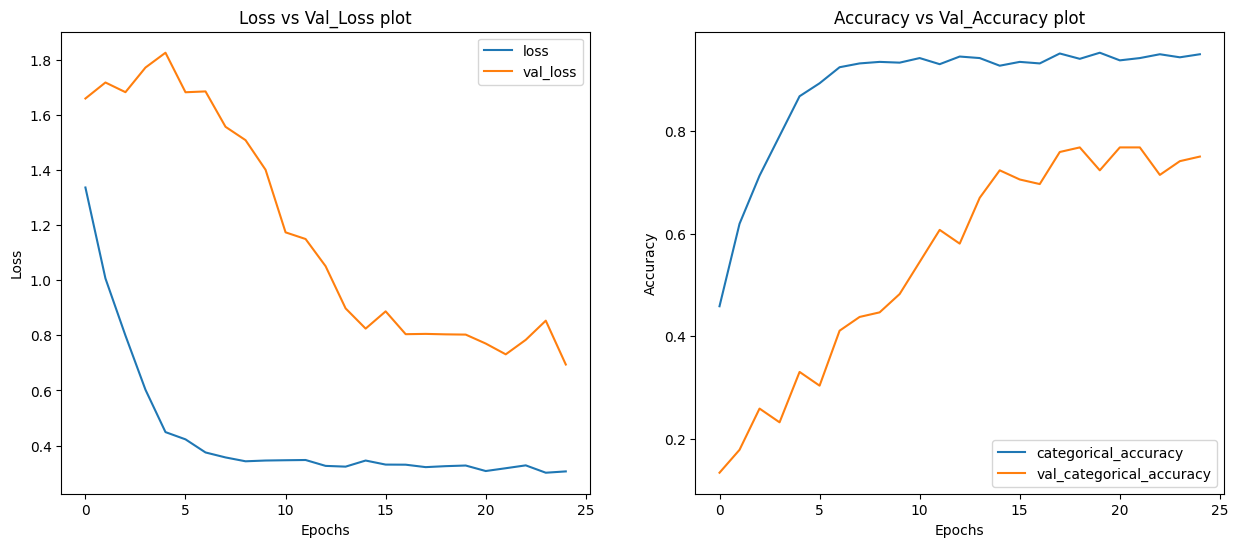

In [9]:

Model_history=train_model(model,epoch=30,train_doc=train_doc,val_doc=val_doc,
                           name='Model13',ip_img_size=(85,85),batch_size=16,
                          img_idx=[i for i in range(0,30)],
                          lr_reduce_factor=0.1,es_patience=5)

## Trying with Image augmentation techniques

### Model 14

In [10]:
# We have model 10 with highest accuracy so trying the same model with augmentation

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3),padding='same', activation='relu'),input_shape=(30,85,85,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#42
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#21
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#10
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#5
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#2
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
#1

model.add(TimeDistributed(Flatten()))

model.add(LSTM(40))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [11]:
model = compile_(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 85, 85, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 85, 85, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 42, 42, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 42, 42, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 42, 42, 32)  

In [12]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model14',ip_img_size=(85,85),batch_size=16,
                          img_idx=[i for i in range(0,30)],
                          lr_reduce_factor=0.2,augment=True)

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (85, 85)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] having length 30
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 16 but the actual batch size post augmentation is 32 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/time_distributed_1/batch_normalization_10/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\1268692137.py", line 1, in <module>
      Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 171, in train_model
      [history,model_path] = fit_model(model,epoch,train_doc,val_doc,batch_size=batch_size,name=name,min_lr=min_lr,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 77, in fit_model
      return [model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\rnn\time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_1/time_distributed_1/batch_normalization_10/FusedBatchNormV3'
OOM when allocating tensor with shape[960,16,85,85] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/time_distributed_1/batch_normalization_10/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8202]

<b> Model training failed with OOM with batch size 16 so lets try with batch size 8.

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (85, 85)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 8
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] having length 30
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 8 but the actual batch size post augmentation is 16 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 83
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.2941 - categorical_accuracy: 0.4583Source 

83/83 [==============================] - 181s 2s/step - loss: 0.0351 - categorical_accuracy: 0.9962 - val_loss: 0.3628 - val_categorical_accuracy: 0.8600 - lr: 4.0000e-05
Epoch 18/25
83/83 [==============================] - ETA: 0s - loss: 0.0304 - categorical_accuracy: 0.9962
Epoch 18: saving model to Model14_2023-01-0222_12_05.261549\Model14-epoch_00018-loss_0.03042-cat_acc_0.99621-val_loss_0.45777-val_acc_0.87000.h5
83/83 [==============================] - 177s 2s/step - loss: 0.0304 - categorical_accuracy: 0.9962 - val_loss: 0.4578 - val_categorical_accuracy: 0.8700 - lr: 4.0000e-05
Epoch 19/25
83/83 [==============================] - ETA: 0s - loss: 0.0315 - categorical_accuracy: 0.9955
Epoch 19: saving model to Model14_2023-01-0222_12_05.261549\Model14-epoch_00019-loss_0.03147-cat_acc_0.99545-val_loss_0.57824-val_acc_0.82500.h5
83/83 [==============================] - 179s 2s/step - loss: 0.0315 - categorical_accuracy: 0.9955 - val_loss: 0.5782 - val_categorical_accuracy: 0.8250 

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.294105              0.458333  1.983629                     0.240   
2      0.980167              0.639394  2.226197                     0.290   
3      0.883882              0.655303  2.435668                     0.285   
4      0.649650              0.771212  2.222609                     0.275   
5      0.419288              0.859091  1.847758                     0.415   
6      0.309579              0.912121  1.253635                     0.595   
7      0.253335              0.921970  0.868763                     0.730   
8      0.193980              0.948485  0.837873                     0.715   
9      0.150070              0.961364  0.471808                     0.830   
10     0.109774              0.975758  0.629480                     0.800   
11     0.084621              0.981818  0.448831                     0.865   
12     0.065691              0.985606  0.407656                     0.895   
13     0.057553              0.985606  0.552328                     0.805   
14     0.043286              0.994697  0.616392                     0.840   
15     0.066504              0.987121  0.689688                     0.780   
16     0.060425              0.984091  0.710802                     0.805   
17     0.035055              0.996212  0.362808                     0.860   
18     0.030418              0.996212  0.457771                     0.870   
19     0.031467              0.995455  0.578242                     0.825   
20     0.024368              0.998485  0.340695                     0.905   
21     0.024955              0.996970  0.430944                     0.870   
22     0.017405              0.999242  0.436167                     0.850   
23     0.018794              0.999242  0.491329                     0.850   
24     0.017689              0.999242  0.507952                     0.845   
25     0.018381              0.998485  0.538742                     0.840   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.218333  
2      0.00100          0.349394  
3      0.00100          0.370303  
4      0.00100          0.496212  
5      0.00020          0.444091  
6      0.00020          0.317121  
7      0.00020          0.191970  
8      0.00020          0.233485  
9      0.00020          0.131364  
10     0.00020          0.175758  
11     0.00020          0.116818  
12     0.00020          0.090606  
13     0.00020          0.180606  
14     0.00020          0.154697  
15     0.00020          0.207121  
16     0.00004          0.179091  
17     0.00004          0.136212  
18     0.00004          0.126212  
19     0.00004          0.170455  
20     0.00004          0.093485  
21     0.00004          0.126970  
22     0.00004          0.149242  
23     0.00004          0.149242  
24     0.00001          0.154242  
25     0.00001          0.158485

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
12     0.065691              0.985606  0.407656                     0.895   

           lr  Acc_val-acc_diff  
Epoch                            
12     0.0002          0.090606

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
20     0.024368              0.998485  0.340695                     0.905   

            lr  Acc_val-acc_diff  
Epoch                             
20     0.00004          0.093485

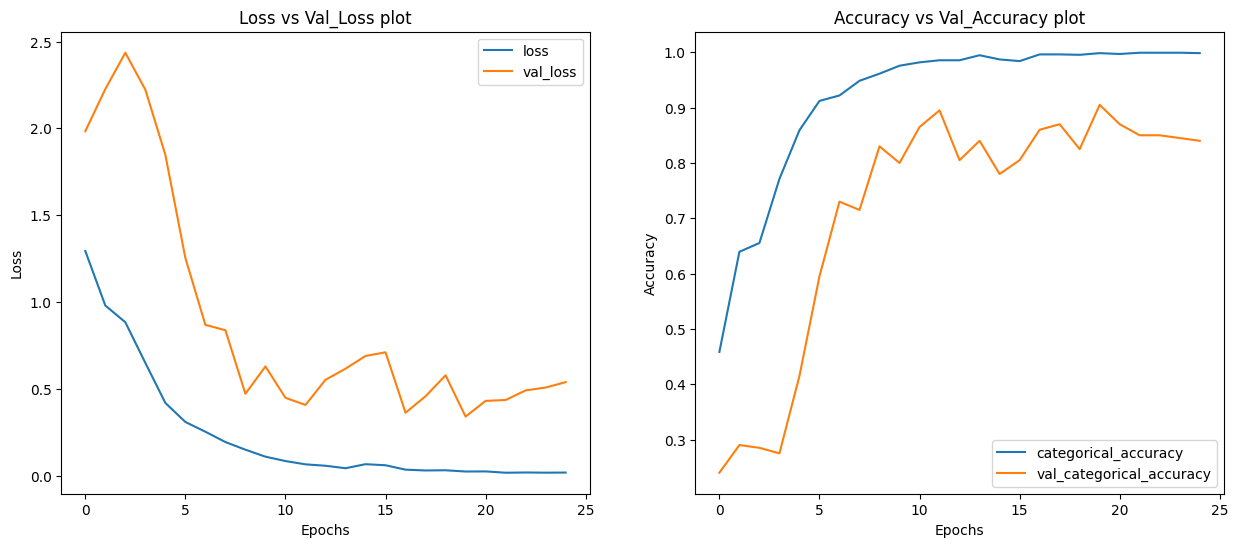

In [11]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model14',ip_img_size=(85,85),batch_size=8,
                          img_idx=[i for i in range(0,30)],
                          lr_reduce_factor=0.2,augment=True)

### Model 15

In [8]:
### Trying Model 6 from CNN using augmentation

In [7]:
model = Sequential()
model.add(Conv3D(16, 3,input_shape=(16,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#7,39,39,16

model.add(Conv3D(32, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
#5,37,37,32

model.add(Conv3D(64, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#2,17,17,64

model.add(Conv3D(32, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#1,8,8,32

model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [8]:
model = compile_(model,optimiser=optimizers.SGD(learning_rate=0.1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 78, 78, 16)    1312      
                                                                 
 activation (Activation)     (None, 14, 78, 78, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 14, 78, 78, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 39, 39, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 37, 37, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 5, 37, 37, 32)     0

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29] having length 16
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 5
     9. Augmentation: True

The given batch size is 16 but the actual batch size post augmentation is 32 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 1.6118 - categorical_accuracy: 0.3622Source path =  Project_data\val ; batch size = 16

Epoc

Epoch 18/25
42/42 [==============================] - ETA: 0s - loss: 0.1770 - categorical_accuracy: 0.9428
Epoch 18: saving model to Model15_2023-01-0307_31_31.264807\Model15-epoch_00018-loss_0.17704-cat_acc_0.94277-val_loss_0.57048-val_acc_0.81731.h5

Epoch 18: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
42/42 [==============================] - 91s 2s/step - loss: 0.1770 - categorical_accuracy: 0.9428 - val_loss: 0.5705 - val_categorical_accuracy: 0.8173 - lr: 1.0000e-03
Epoch 19/25
42/42 [==============================] - ETA: 0s - loss: 0.1879 - categorical_accuracy: 0.9503
Epoch 19: saving model to Model15_2023-01-0307_31_31.264807\Model15-epoch_00019-loss_0.18791-cat_acc_0.95030-val_loss_0.67276-val_acc_0.77404.h5
42/42 [==============================] - 91s 2s/step - loss: 0.1879 - categorical_accuracy: 0.9503 - val_loss: 0.6728 - val_categorical_accuracy: 0.7740 - lr: 1.0000e-04
Epoch 20/25
42/42 [==============================] - ETA: 0s - loss: 0.1758 - 

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy   val_loss  val_categorical_accuracy  \
Epoch                                                                        
1      1.611802              0.362199  14.202312                  0.206731   
2      1.264216              0.469880   5.492439                  0.269231   
3      1.090506              0.552711   3.815708                  0.211538   
4      0.956039              0.611446   3.637165                  0.302885   
5      0.767013              0.710843   2.025697                  0.394231   
6      0.668772              0.753012   0.845960                  0.682692   
7      0.590179              0.777861   1.711844                  0.490385   
8      0.499660              0.820030   1.116344                  0.634615   
9      0.416276              0.845633   1.114274                  0.673077   
10     0.350632              0.878765   0.796122                  0.721154   
11     0.289624              0.906627   0.580316                  0.802885   
12     0.227478              0.928464   0.533834                  0.826923   
13     0.217267              0.931476   0.755741                  0.735577   
14     0.197085              0.936747   0.574127                  0.807692   
15     0.236200              0.932982   0.637556                  0.774038   
16     0.184439              0.942018   0.627139                  0.759615   
17     0.186432              0.939759   0.566869                  0.812500   
18     0.177042              0.942771   0.570480                  0.817308   
19     0.187913              0.950301   0.672756                  0.774038   
20     0.175801              0.949548   0.722944                  0.788462   
21     0.178246              0.945783   0.686514                  0.778846   
22     0.213773              0.939006   0.749308                  0.788462   
23     0.189707              0.938253   0.723365                  0.774038   
24     0.161076              0.950301   0.729686                  0.798077   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.10000          0.155468  
2      0.10000          0.200649  
3      0.10000          0.341172  
4      0.10000          0.308561  
5      0.10000          0.316613  
6      0.10000          0.070320  
7      0.10000          0.287477  
8      0.10000          0.185415  
9      0.10000          0.172556  
10     0.01000          0.157611  
11     0.01000          0.103742  
12     0.01000          0.101541  
13     0.01000          0.195899  
14     0.01000          0.129055  
15     0.01000          0.158943  
16     0.00100          0.182403  
17     0.00100          0.127259  
18     0.00100          0.125463  
19     0.00010          0.176263  
20     0.00010          0.161087  
21     0.00010          0.166937  
22     0.00001          0.150544  
23     0.00001          0.164215  
24     0.00001          0.152224

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
12     0.227478              0.928464  0.533834                  0.826923   

         lr  Acc_val-acc_diff  
Epoch                          
12     0.01          0.101541

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
12     0.227478              0.928464  0.533834                  0.826923   

         lr  Acc_val-acc_diff  
Epoch                          
12     0.01          0.101541

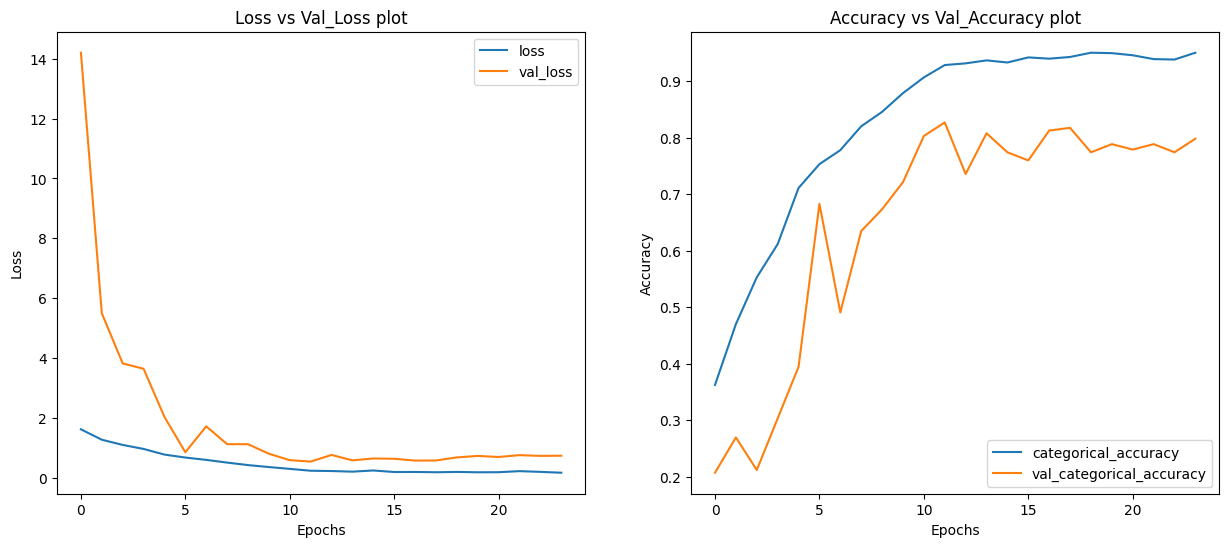

In [9]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model15',ip_img_size=(80,80),batch_size=16,
                        img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29],
                          lr_reduce_factor=0.1,augment=True,es_patience=5)

### Model 16

In [18]:
model = Sequential()
model.add(Conv3D(16, 3,padding='same',input_shape=(16,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#8,40,40,16

model.add(Conv3D(32, 3))
model.add(Activation('relu'))
model.add(BatchNormalization())
#6,38,38,32

model.add(Conv3D(64, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#3,19,19,64

model.add(Conv3D(32, 3,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#1,9,9,32

model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [19]:
model = compile_(model)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 80, 80, 16)    1312      
                                                                 
 activation_16 (Activation)  (None, 16, 80, 80, 16)    0         
                                                                 
 batch_normalization_28 (Bat  (None, 16, 80, 80, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 8, 40, 40, 16)    0         
 3D)                                                             
                                                                 
 conv3d_17 (Conv3D)          (None, 6, 38, 38, 32)     13856     
                                                                 
 activation_17 (Activation)  (None, 6, 38, 38, 32)    

In [20]:
Model_history=train_model(model,epoch=30,train_doc=train_doc,val_doc=val_doc,
                           name='Model16',ip_img_size=(80,80),batch_size=16,
                        img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29],
                          lr_reduce_factor=0.1,augment=True,es_patience=5)

Hyperparameter values-
     1. Epoch: 30
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 16
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29] having length 16
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 5
     9. Augmentation: True

The given batch size is 16 but the actual batch size post augmentation is 32 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 42
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 16
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.6174 - categorical_accuracy: 0.3946Source path =  Project_data\val ; batch size = 16

Epoc

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_4/batch_normalization_28/FusedBatchNormGradV3' defined at (most recent call last):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\515363108.py", line 1, in <module>
      Model_history=train_model(model,epoch=30,train_doc=train_doc,val_doc=val_doc,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 171, in train_model
      [history,model_path] = fit_model(model,epoch,train_doc,val_doc,batch_size=batch_size,name=name,min_lr=min_lr,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 77, in fit_model
      return [model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_4/batch_normalization_28/FusedBatchNormGradV3'
OOM when allocating tensor with shape[32,16,16,6400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_4/batch_normalization_28/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13124]

Hyperparameter values-
     1. Epoch: 30
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.1
     4. Batch Size: 12
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29] having length 16
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 5
     9. Augmentation: True

The given batch size is 12 but the actual batch size post augmentation is 24 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 56
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 12
Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 1.5753 - categorical_accuracy: 0.3889Source path =  Project_data\val ; batch size = 12

Epoc

Epoch 18/30
56/56 [==============================] - ETA: 0s - loss: 0.2828 - categorical_accuracy: 0.9092
Epoch 18: saving model to Model16_2023-01-0310_37_01.387946\Model16-epoch_00018-loss_0.28283-cat_acc_0.90916-val_loss_0.45167-val_acc_0.83333.h5

Epoch 18: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
56/56 [==============================] - 99s 2s/step - loss: 0.2828 - categorical_accuracy: 0.9092 - val_loss: 0.4517 - val_categorical_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 19/30
56/56 [==============================] - ETA: 0s - loss: 0.2398 - categorical_accuracy: 0.9242
Epoch 19: saving model to Model16_2023-01-0310_37_01.387946\Model16-epoch_00019-loss_0.23981-cat_acc_0.92417-val_loss_0.41891-val_acc_0.84804.h5
56/56 [==============================] - 100s 2s/step - loss: 0.2398 - categorical_accuracy: 0.9242 - val_loss: 0.4189 - val_categorical_accuracy: 0.8480 - lr: 1.0000e-05
Epoch 20/30
56/56 [==============================] - ETA: 0s - loss: 0.2559 

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.575285              0.388889  1.736427                  0.240196   
2      1.134133              0.554805  2.681704                  0.235294   
3      0.943577              0.634384  2.316221                  0.264706   
4      0.797798              0.699700  2.233413                  0.289216   
5      0.562080              0.790541  1.973123                  0.348039   
6      0.507757              0.818318  1.541687                  0.431373   
7      0.474759              0.840090  1.428296                  0.480392   
8      0.438469              0.852102  1.167104                  0.553922   
9      0.402839              0.854354  1.057436                  0.612745   
10     0.387725              0.873123  0.776595                  0.720588   
11     0.393414              0.866366  0.649884                  0.774510   
12     0.343039              0.894895  0.569858                  0.803922   
13     0.345927              0.892643  0.553875                  0.803922   
14     0.305008              0.905405  0.581949                  0.813725   
15     0.282376              0.912162  0.445838                  0.848039   
16     0.313362              0.891141  0.535789                  0.799020   
17     0.270896              0.911411  0.460239                  0.843137   
18     0.282834              0.909159  0.451674                  0.833333   
19     0.239810              0.924174  0.418913                  0.848039   
20     0.255925              0.922673  0.342300                  0.877451   
21     0.218823              0.939189  0.456950                  0.848039   
22     0.275158              0.918919  0.395329                  0.848039   
23     0.236155              0.937688  0.393089                  0.862745   
24     0.241258              0.929429  0.363508                  0.882353   
25     0.235571              0.927177  0.475556                  0.813725   
26     0.223870              0.934685  0.385615                  0.882353   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.148693  
2      0.00100          0.319511  
3      0.00100          0.369678  
4      0.00100          0.410484  
5      0.00010          0.442501  
6      0.00010          0.386946  
7      0.00010          0.359698  
8      0.00010          0.298181  
9      0.00010          0.241609  
10     0.00010          0.152535  
11     0.00010          0.091857  
12     0.00010          0.090973  
13     0.00010          0.088721  
14     0.00010          0.091680  
15     0.00010          0.064123  
16     0.00010          0.092121  
17     0.00010          0.068274  
18     0.00010          0.075826  
19     0.00001          0.076135  
20     0.00001          0.045222  
21     0.00001          0.091150  
22     0.00001          0.070880  
23     0.00001          0.074943  
24     0.00001          0.047076  
25     0.00001          0.113452  
26     0.00001          0.052332

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
20     0.255925              0.922673    0.3423                  0.877451   

            lr  Acc_val-acc_diff  
Epoch                             
20     0.00001          0.045222

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
24     0.241258              0.929429  0.363508                  0.882353   
26     0.223870              0.934685  0.385615                  0.882353   

            lr  Acc_val-acc_diff  
Epoch                             
24     0.00001          0.047076  
26     0.00001          0.052332

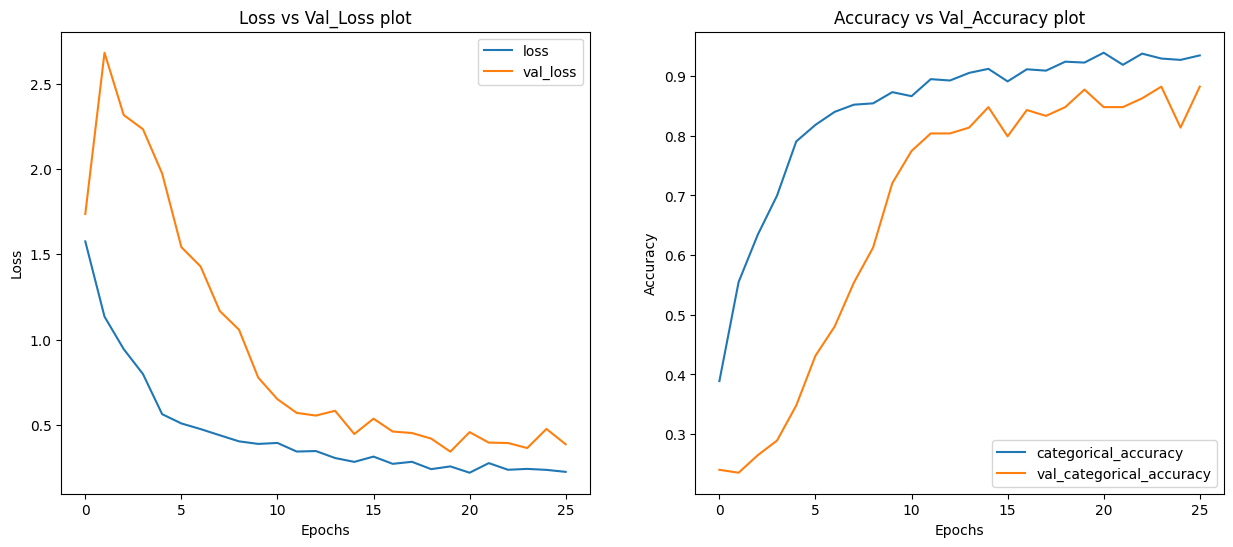

In [9]:
Model_history=train_model(model,epoch=30,train_doc=train_doc,val_doc=val_doc,
                           name='Model16',ip_img_size=(80,80),batch_size=12,
                        img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29],
                          lr_reduce_factor=0.1,augment=True,es_patience=5)

### Model 17 - LSTM

In [10]:
# We have model 9 with highest accuracy so trying the same model with augmentation

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(15,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.2))

model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

In [11]:
model = compile_(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 50, 50, 32)  

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (100, 100)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 8
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 8 but the actual batch size post augmentation is 16 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 83
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.5564 - categorical_accuracy: 0.3106Source path =  Project_data\val ; batch size = 8

Epoch 1: s

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.556406              0.310606  1.604179                     0.230   
2      1.391679              0.460606  1.600845                     0.200   
3      1.279994              0.533333  1.627749                     0.245   
4      1.170346              0.608333  1.640781                     0.240   
5      1.089220              0.633333  1.551979                     0.370   
6      0.997572              0.703030  1.424162                     0.410   
7      0.937060              0.723485  1.383187                     0.390   
8      0.891283              0.720455  1.055463                     0.585   
9      0.837643              0.750758  0.983368                     0.675   
10     0.764730              0.786364  0.878769                     0.710   
11     0.747935              0.784849  0.838236                     0.745   
12     0.694036              0.810606  0.856744                     0.745   
13     0.666744              0.823485  0.834074                     0.720   
14     0.626837              0.845455  0.757479                     0.785   
15     0.591426              0.850000  0.777700                     0.775   
16     0.544752              0.881818  0.814273                     0.750   
17     0.523315              0.859091  0.714867                     0.775   
18     0.483042              0.893182  0.762877                     0.755   
19     0.458962              0.903788  0.652637                     0.795   
20     0.438031              0.912879  0.819157                     0.740   
21     0.422299              0.914394  0.666379                     0.820   
22     0.367712              0.932576  0.745578                     0.780   
23     0.373002              0.931818  0.597658                     0.810   
24     0.347224              0.944697  0.695981                     0.795   
25     0.332206              0.942424  0.676400                     0.755   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00001          0.080606  
2      0.00001          0.260606  
3      0.00001          0.288333  
4      0.00001          0.368333  
5      0.00001          0.263333  
6      0.00001          0.293030  
7      0.00001          0.333485  
8      0.00001          0.135455  
9      0.00001          0.075758  
10     0.00001          0.076364  
11     0.00001          0.039849  
12     0.00001          0.065606  
13     0.00001          0.103485  
14     0.00001          0.060455  
15     0.00001          0.075000  
16     0.00001          0.131818  
17     0.00001          0.084091  
18     0.00001          0.138182  
19     0.00001          0.108788  
20     0.00001          0.172879  
21     0.00001          0.094394  
22     0.00001          0.152576  
23     0.00001          0.121818  
24     0.00001          0.149697  
25     0.00001          0.187424

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
11     0.747935              0.784849  0.838236                     0.745   

            lr  Acc_val-acc_diff  
Epoch                             
11     0.00001          0.039849

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
21     0.422299              0.914394  0.666379                      0.82   

            lr  Acc_val-acc_diff  
Epoch                             
21     0.00001          0.094394

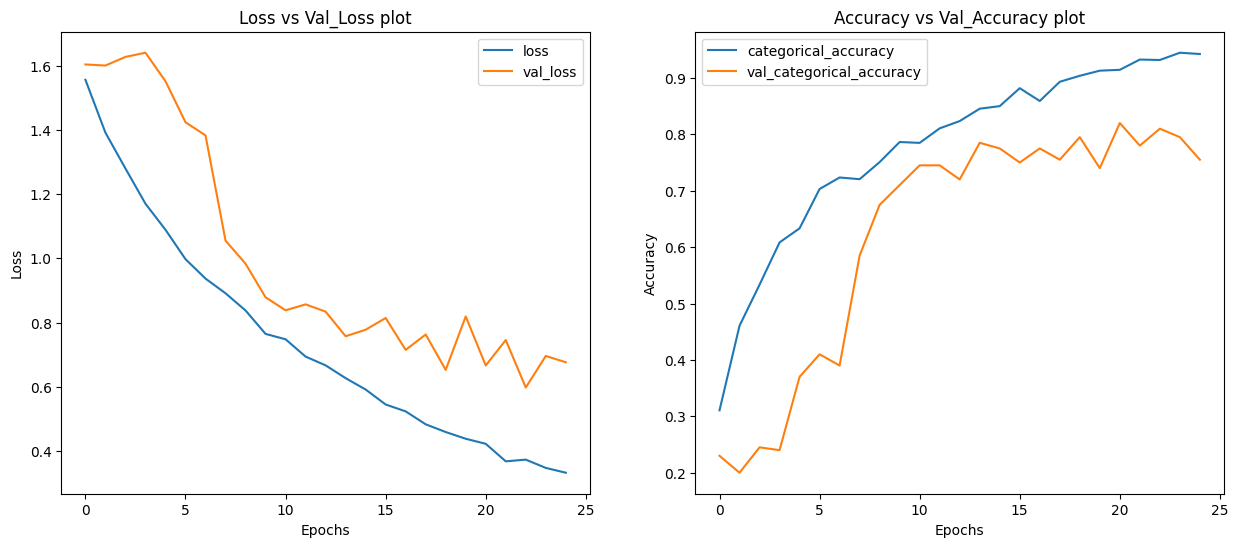

In [12]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model9',ip_img_size=(100,100),batch_size=8,
                          lr_reduce_factor=0.2,augment=True)

### <center> Pretrained Models

### Model 18 - Mobilenet model without augmentation

In [8]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(15,100,100,3)))


model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [9]:
model = compile_(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)                2

Hyperparameter values-
     1. Epoch: 30
     2. Crop size of Frame: (100, 100)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 8
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: False

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 83
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 8
Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 1.0887 - categorical_accuracy: 0.6009Source path =  Project_data\val ; batch size = 8

Epoch 1: saving model to Model18_2023-01-0312_12_28.809298\Model18-epoch_00001-loss_1.08868-cat_acc_0.60090-val_loss_0.90306-val_acc_0.74038.h5
83/83 [==============================]

Epoch 18/30
83/83 [==============================] - ETA: 0s - loss: 0.0340 - categorical_accuracy: 0.9970
Epoch 18: saving model to Model18_2023-01-0312_12_28.809298\Model18-epoch_00018-loss_0.03404-cat_acc_0.99699-val_loss_0.19000-val_acc_0.95192.h5
83/83 [==============================] - 63s 771ms/step - loss: 0.0340 - categorical_accuracy: 0.9970 - val_loss: 0.1900 - val_categorical_accuracy: 0.9519 - lr: 1.0000e-05
Epoch 19/30
83/83 [==============================] - ETA: 0s - loss: 0.0299 - categorical_accuracy: 0.9970
Epoch 19: saving model to Model18_2023-01-0312_12_28.809298\Model18-epoch_00019-loss_0.02990-cat_acc_0.99699-val_loss_0.09164-val_acc_0.98077.h5
83/83 [==============================] - 65s 794ms/step - loss: 0.0299 - categorical_accuracy: 0.9970 - val_loss: 0.0916 - val_categorical_accuracy: 0.9808 - lr: 1.0000e-05
Epoch 20/30
83/83 [==============================] - ETA: 0s - loss: 0.0595 - categorical_accuracy: 0.9925
Epoch 20: saving model to Model18_2023-01-0

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.088684              0.600904  0.903060                  0.740385   
2      0.540537              0.837349  0.556132                  0.759615   
3      0.487182              0.849398  0.635534                  0.807692   
4      0.346095              0.909639  0.567061                  0.817308   
5      0.230441              0.944277  0.234250                  0.923077   
6      0.157861              0.956325  0.455736                  0.855769   
7      0.240425              0.932229  0.431185                  0.884615   
8      0.250176              0.929217  0.305115                  0.932692   
9      0.169534              0.954819  0.089646                  0.961538   
10     0.087961              0.975904  0.203144                  0.951923   
11     0.059535              0.987952  0.149899                  0.971154   
12     0.058899              0.987952  0.124856                  0.980769   
13     0.034750              0.990964  0.149739                  0.971154   
14     0.035527              0.990964  0.152536                  0.971154   
15     0.034230              0.993976  0.150651                  0.971154   
16     0.035403              0.995482  0.232840                  0.951923   
17     0.033086              0.992470  0.184858                  0.971154   
18     0.034041              0.996988  0.189999                  0.951923   
19     0.029903              0.996988  0.091641                  0.980769   
20     0.059509              0.992470  0.157675                  0.971154   
21     0.034831              0.995482  0.094371                  0.980769   
22     0.033042              0.996988  0.173914                  0.971154   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.139481  
2      0.00100          0.077734  
3      0.00100          0.041705  
4      0.00100          0.092331  
5      0.00100          0.021200  
6      0.00100          0.100556  
7      0.00100          0.047614  
8      0.00100          0.003475  
9      0.00020          0.006719  
10     0.00020          0.023981  
11     0.00020          0.016798  
12     0.00020          0.007183  
13     0.00004          0.019810  
14     0.00004          0.019810  
15     0.00004          0.022822  
16     0.00001          0.043559  
17     0.00001          0.021316  
18     0.00001          0.045065  
19     0.00001          0.016219  
20     0.00001          0.021316  
21     0.00001          0.014713  
22     0.00001          0.025834

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
8      0.250176              0.929217  0.305115                  0.932692   

          lr  Acc_val-acc_diff  
Epoch                           
8      0.001          0.003475

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
12     0.058899              0.987952  0.124856                  0.980769   
19     0.029903              0.996988  0.091641                  0.980769   
21     0.034831              0.995482  0.094371                  0.980769   

            lr  Acc_val-acc_diff  
Epoch                             
12     0.00020          0.007183  
19     0.00001          0.016219  
21     0.00001          0.014713

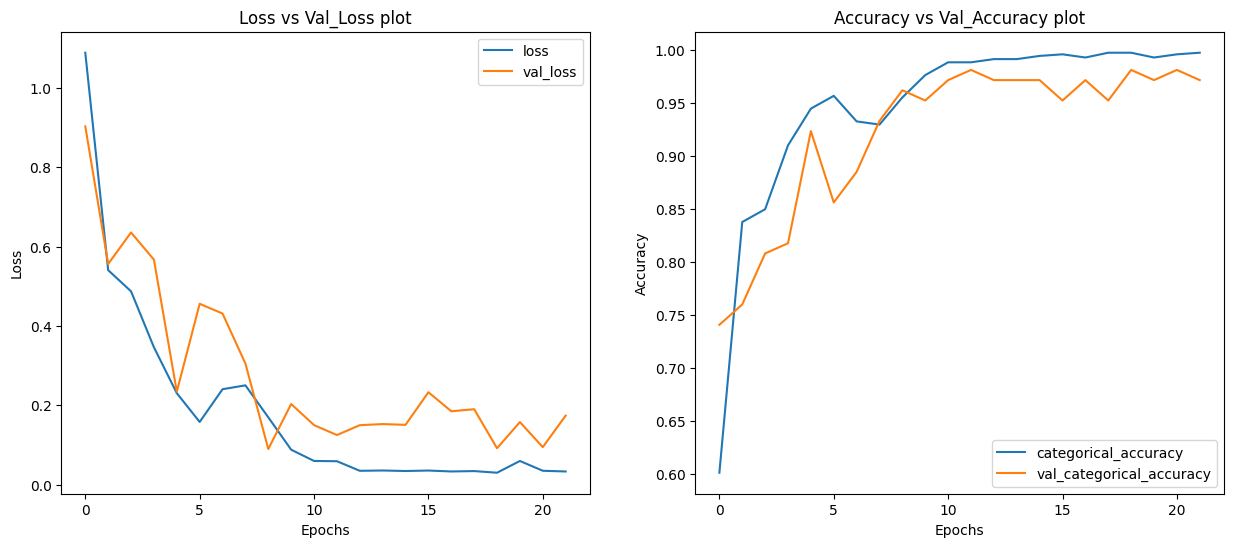

In [10]:
Model_history=train_model(model,epoch=30,train_doc=train_doc,val_doc=val_doc,
                           name='Model18',ip_img_size=(100,100),batch_size=8,
                          img_idx=[i for i in range(0,30,2)])

### Model 19 - Mobilenet model with augmentation

In [21]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(15,80,80,3)))


model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [22]:
model = compile_(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 15, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 2, 2, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)               

In [23]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model19',ip_img_size=(80,80),batch_size=8,
                          img_idx=[i for i in range(0,30,2)],augment=True)

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 8
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 8 but the actual batch size post augmentation is 16 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 83
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 8
Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_5/time_distributed_19/mobilenet_1.00_224/conv_pw_11_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\2020014026.py", line 1, in <module>
      Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 171, in train_model
      [history,model_path] = fit_model(model,epoch,train_doc,val_doc,batch_size=batch_size,name=name,min_lr=min_lr,
    File "C:\Users\sthul\AppData\Local\Temp\ipykernel_22232\70187884.py", line 77, in fit_model
      return [model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\rnn\time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\sthul\anaconda3\envs\TC_\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_5/time_distributed_19/mobilenet_1.00_224/conv_pw_11_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[240,512,5,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_5/time_distributed_19/mobilenet_1.00_224/conv_pw_11_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_25529]

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 4
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 4 but the actual batch size post augmentation is 8 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 166
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.2257 - categorical_accuracy: 0.5181Source path =  Project_data\val ; batch size = 4

Epoch 1: s

Epoch 18/25
166/166 [==============================] - ETA: 0s - loss: 0.0871 - categorical_accuracy: 0.9826
Epoch 18: saving model to Model19_2023-01-0312_41_48.943528\Model19-epoch_00018-loss_0.08706-cat_acc_0.98263-val_loss_0.34693-val_acc_0.91500.h5

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
166/166 [==============================] - 96s 582ms/step - loss: 0.0871 - categorical_accuracy: 0.9826 - val_loss: 0.3469 - val_categorical_accuracy: 0.9150 - lr: 2.0000e-04
Epoch 19/25
166/166 [==============================] - ETA: 0s - loss: 0.0599 - categorical_accuracy: 0.9834
Epoch 19: saving model to Model19_2023-01-0312_41_48.943528\Model19-epoch_00019-loss_0.05985-cat_acc_0.98338-val_loss_0.27432-val_acc_0.93500.h5
166/166 [==============================] - 96s 577ms/step - loss: 0.0599 - categorical_accuracy: 0.9834 - val_loss: 0.2743 - val_categorical_accuracy: 0.9350 - lr: 4.0000e-05
Epoch 20/25
166/166 [==============================] - ETA: 0s 

<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.225726              0.518127  0.705744                     0.750   
2      0.708549              0.774169  0.718072                     0.750   
3      0.523155              0.854985  0.556343                     0.845   
4      0.476818              0.854985  0.464830                     0.885   
5      0.328361              0.913897  0.499707                     0.870   
6      0.389477              0.883686  0.374176                     0.890   
7      0.358352              0.903323  0.576881                     0.820   
8      0.401142              0.884441  0.599650                     0.825   
9      0.261415              0.932779  0.350389                     0.865   
10     0.322746              0.910121  0.370116                     0.905   
11     0.267298              0.929758  0.712553                     0.845   
12     0.234269              0.938822  0.190920                     0.935   
13     0.169799              0.951662  0.953185                     0.800   
14     0.228422              0.941843  0.543706                     0.875   
15     0.225515              0.939577  0.520932                     0.835   
16     0.123498              0.968278  0.359158                     0.890   
17     0.069982              0.986405  0.244927                     0.925   
18     0.087058              0.982628  0.346935                     0.915   
19     0.059851              0.983384  0.274318                     0.935   
20     0.048626              0.993958  0.215937                     0.945   
21     0.046712              0.991692  0.331272                     0.905   
22     0.052426              0.985650  0.216295                     0.935   
23     0.042547              0.988671  0.318282                     0.920   
24     0.043444              0.991692  0.267024                     0.930   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.231873  
2      0.00100          0.024169  
3      0.00100          0.009985  
4      0.00100          0.030015  
5      0.00100          0.043897  
6      0.00100          0.006314  
7      0.00100          0.083323  
8      0.00100          0.059441  
9      0.00100          0.067779  
10     0.00100          0.005121  
11     0.00100          0.084758  
12     0.00100          0.003822  
13     0.00100          0.151662  
14     0.00100          0.066843  
15     0.00100          0.104577  
16     0.00020          0.078278  
17     0.00020          0.061405  
18     0.00020          0.067628  
19     0.00004          0.048384  
20     0.00004          0.048958  
21     0.00004          0.086692  
22     0.00001          0.050650  
23     0.00001          0.068671  
24     0.00001          0.061692

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
12     0.234269              0.938822   0.19092                     0.935   

          lr  Acc_val-acc_diff  
Epoch                           
12     0.001          0.003822

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
20     0.048626              0.993958  0.215937                     0.945   

            lr  Acc_val-acc_diff  
Epoch                             
20     0.00004          0.048958

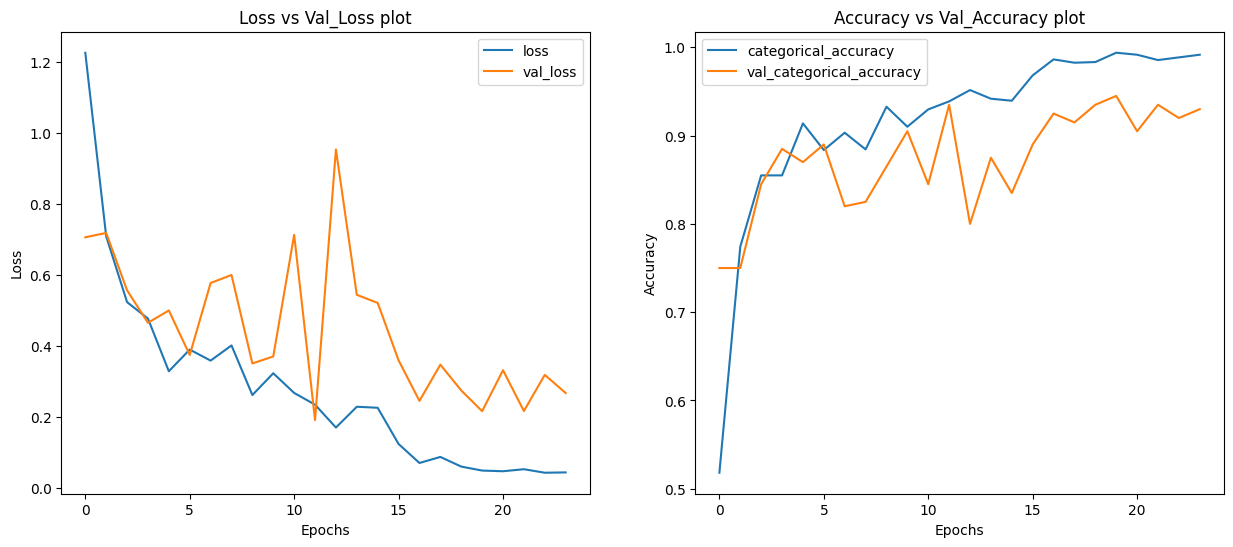

In [9]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model19',ip_img_size=(80,80),batch_size=4,
                          img_idx=[i for i in range(0,30,2)],augment=True)

### Model 20

In [7]:
vgg16 = VGG16(include_top=False,weights='imagenet')        
model = Sequential()
model.add(TimeDistributed(vgg16,input_shape=(15,80,80,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [8]:
model = compile_(model,optimiser=optimizers.Adagrad(learning_rate=0.0001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 2, 2, 512)    14714688  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 2, 2, 512)    2048      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 512)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 512)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                1

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 4
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 4 but the actual batch size post augmentation is 8 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 166
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.6776 - categorical_accuracy: 0.2273Source path =  Project_data\val ; batch size = 4

Epoch 1: s

Epoch 18/25
166/166 [==============================] - ETA: 0s - loss: 0.9757 - categorical_accuracy: 0.7432
Epoch 18: saving model to Model20_2023-01-0410_09_40.431541\Model20-epoch_00018-loss_0.97572-cat_acc_0.74320-val_loss_1.17145-val_acc_0.63000.h5
166/166 [==============================] - 142s 862ms/step - loss: 0.9757 - categorical_accuracy: 0.7432 - val_loss: 1.1715 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 19/25
166/166 [==============================] - ETA: 0s - loss: 0.9565 - categorical_accuracy: 0.7462
Epoch 19: saving model to Model20_2023-01-0410_09_40.431541\Model20-epoch_00019-loss_0.95651-cat_acc_0.74622-val_loss_1.11530-val_acc_0.68000.h5
166/166 [==============================] - 151s 913ms/step - loss: 0.9565 - categorical_accuracy: 0.7462 - val_loss: 1.1153 - val_categorical_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 20/25
166/166 [==============================] - ETA: 0s - loss: 0.8740 - categorical_accuracy: 0.7795
Epoch 20: saving model to Model

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.677606              0.227341  1.619652                     0.230   
2      1.580727              0.283233  1.599191                     0.190   
3      1.543568              0.308912  1.565424                     0.270   
4      1.510027              0.358006  1.502700                     0.335   
5      1.432507              0.413897  1.499773                     0.370   
6      1.403349              0.443353  1.495098                     0.370   
7      1.370106              0.487915  1.425588                     0.420   
8      1.323380              0.509819  1.430368                     0.430   
9      1.275716              0.555136  1.391126                     0.485   
10     1.246666              0.564955  1.331395                     0.525   
11     1.202160              0.597432  1.309417                     0.590   
12     1.168905              0.643505  1.319277                     0.550   
13     1.127640              0.639728  1.258754                     0.580   
14     1.086073              0.676737  1.320121                     0.590   
15     1.052922              0.697885  1.224931                     0.605   
16     1.019069              0.723565  1.165056                     0.635   
17     0.981477              0.741692  1.188991                     0.650   
18     0.975721              0.743202  1.171453                     0.630   
19     0.956507              0.746224  1.115298                     0.680   
20     0.874006              0.779456  1.147174                     0.655   
21     0.868987              0.795317  1.108333                     0.685   
22     0.857159              0.801360  1.059541                     0.720   
23     0.833872              0.805136  1.077530                     0.685   
24     0.793321              0.827795  0.991961                     0.735   
25     0.773025              0.832326  0.993742                     0.705   

           lr  Acc_val-acc_diff  
Epoch                            
1      0.0001          0.002659  
2      0.0001          0.093233  
3      0.0001          0.038912  
4      0.0001          0.023006  
5      0.0001          0.043897  
6      0.0001          0.073353  
7      0.0001          0.067915  
8      0.0001          0.079819  
9      0.0001          0.070136  
10     0.0001          0.039955  
11     0.0001          0.007432  
12     0.0001          0.093505  
13     0.0001          0.059728  
14     0.0001          0.086737  
15     0.0001          0.092885  
16     0.0001          0.088565  
17     0.0001          0.091692  
18     0.0001          0.113202  
19     0.0001          0.066224  
20     0.0001          0.124456  
21     0.0001          0.110317  
22     0.0001          0.081360  
23     0.0001          0.120136  
24     0.0001          0.092795  
25     0.0001          0.127326

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
22     0.857159               0.80136  1.059541                      0.72   

           lr  Acc_val-acc_diff  
Epoch                            
22     0.0001           0.08136

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
24     0.793321              0.827795  0.991961                     0.735   

           lr  Acc_val-acc_diff  
Epoch                            
24     0.0001          0.092795

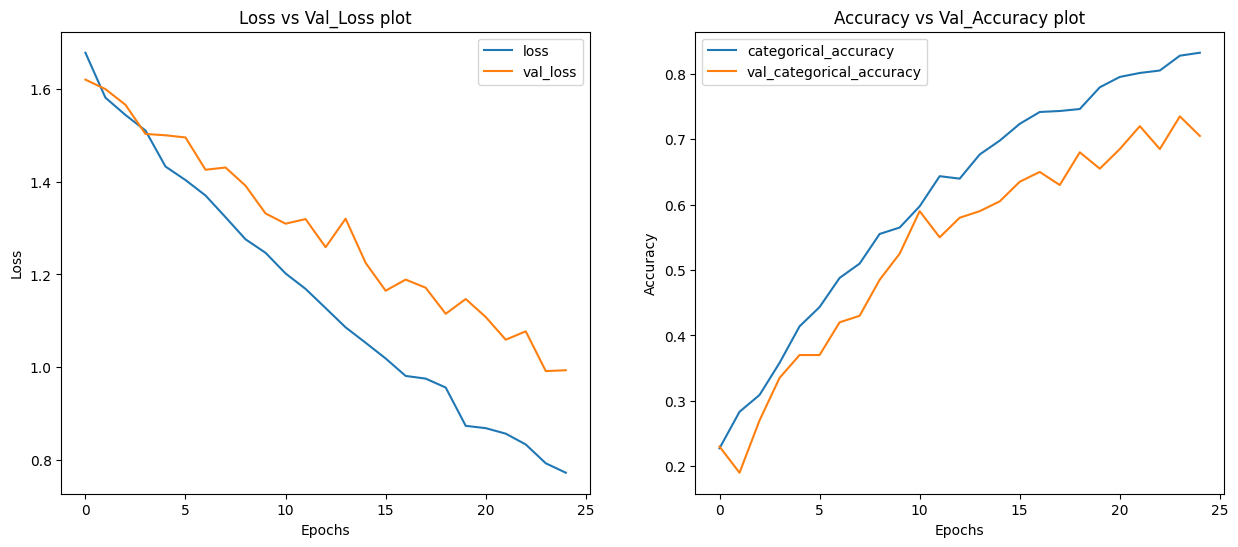

In [9]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model20',ip_img_size=(80,80),batch_size=4,
                          img_idx=[i for i in range(0,30,2)],augment=True)

### Model 21

In [10]:
inception = keras.applications.inception_v3.InceptionV3(include_top=False)
        
model = Sequential()
model.add(TimeDistributed(inception,input_shape=(15,80,80,3)))

model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(50))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [11]:
model=compile_(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 2048)   21802784  
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1, 1, 2048)   8192      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 50)                419800    
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                      

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 4
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 4 but the actual batch size post augmentation is 8 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 166
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.2694 - categorical_accuracy: 0.5083Source path =  Project_data\val ; batch size = 4

Epoch 1: s

166/166 [==============================] - 114s 689ms/step - loss: 0.1465 - categorical_accuracy: 0.9653 - val_loss: 0.4432 - val_categorical_accuracy: 0.8900 - lr: 4.0000e-05
Epoch 18/25
166/166 [==============================] - ETA: 0s - loss: 0.1493 - categorical_accuracy: 0.9615
Epoch 18: saving model to Model21_2023-01-0412_04_13.102872\Model21-epoch_00018-loss_0.14928-cat_acc_0.96148-val_loss_0.51582-val_acc_0.83500.h5
166/166 [==============================] - 116s 702ms/step - loss: 0.1493 - categorical_accuracy: 0.9615 - val_loss: 0.5158 - val_categorical_accuracy: 0.8350 - lr: 4.0000e-05
Epoch 19/25
166/166 [==============================] - ETA: 0s - loss: 0.1235 - categorical_accuracy: 0.9705
Epoch 19: saving model to Model21_2023-01-0412_04_13.102872\Model21-epoch_00019-loss_0.12352-cat_acc_0.97054-val_loss_0.46271-val_acc_0.87000.h5
166/166 [==============================] - 114s 691ms/step - loss: 0.1235 - categorical_accuracy: 0.9705 - val_loss: 0.4627 - val_categorica

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.269421              0.508308  1.456988                     0.355   
2      1.070041              0.626888  1.486076                     0.365   
3      1.061721              0.640483  1.480901                     0.405   
4      1.169057              0.559668  1.517614                     0.425   
5      1.043562              0.605740  1.112774                     0.580   
6      0.778595              0.737915  0.848298                     0.710   
7      0.591485              0.803625  0.740627                     0.730   
8      0.505472              0.830816  0.839339                     0.775   
9      0.416707              0.876888  0.551053                     0.845   
10     0.358164              0.901813  0.720812                     0.815   
11     0.336881              0.896526  0.913873                     0.750   
12     0.260710              0.924471  0.495064                     0.855   
13     0.329861              0.901057  0.631302                     0.815   
14     0.209794              0.941088  0.684147                     0.800   
15     0.186916              0.944864  0.580837                     0.860   
16     0.140415              0.968278  0.529025                     0.835   
17     0.146525              0.965257  0.443155                     0.890   
18     0.149278              0.961480  0.515816                     0.835   
19     0.123523              0.970544  0.462711                     0.870   
20     0.122152              0.968278  0.396174                     0.880   
21     0.083757              0.980363  0.574872                     0.855   
22     0.111650              0.978097  0.403225                     0.880   
23     0.093444              0.978852  0.560139                     0.850   
24     0.085824              0.979607  0.460737                     0.880   
25     0.076337              0.983384  0.481459                     0.875   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.153308  
2      0.00100          0.261888  
3      0.00100          0.235483  
4      0.00100          0.134668  
5      0.00020          0.025740  
6      0.00020          0.027915  
7      0.00020          0.073625  
8      0.00020          0.055816  
9      0.00020          0.031888  
10     0.00020          0.086813  
11     0.00020          0.146526  
12     0.00020          0.069471  
13     0.00020          0.086057  
14     0.00020          0.141088  
15     0.00020          0.084864  
16     0.00004          0.133278  
17     0.00004          0.075257  
18     0.00004          0.126480  
19     0.00004          0.100544  
20     0.00004          0.088278  
21     0.00004          0.125363  
22     0.00004          0.098097  
23     0.00004          0.128852  
24     0.00001          0.099607  
25     0.00001          0.108384

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
6      0.778595              0.737915  0.848298                      0.71   

           lr  Acc_val-acc_diff  
Epoch                            
6      0.0002          0.027915

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
17     0.146525              0.965257  0.443155                      0.89   

            lr  Acc_val-acc_diff  
Epoch                             
17     0.00004          0.075257

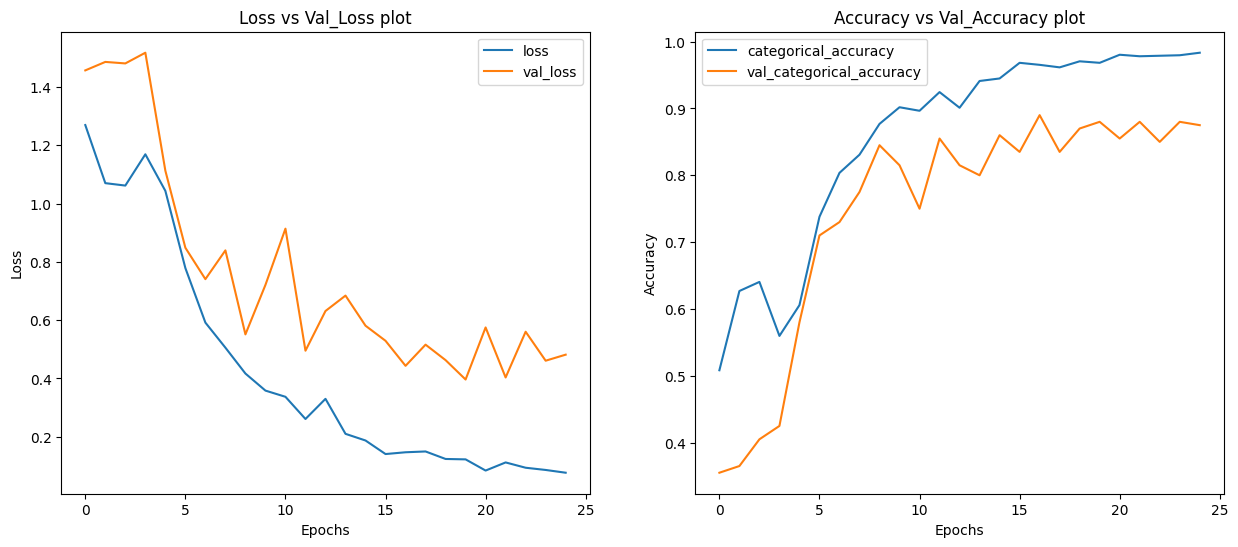

In [12]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model21',ip_img_size=(80,80),batch_size=4,
                          img_idx=[i for i in range(0,30,2)],augment=True)

### Model 22

In [10]:
MobileNetV2 = keras.applications.MobileNetV2(include_top=False)
        
model = Sequential()
model.add(TimeDistributed(MobileNetV2,input_shape=(15,80,80,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(50))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

9406464/9406464 [==============================] - 1s 0us/step


In [11]:
model = compile_(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 2, 2, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 2, 2, 1280)   5120      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1280)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1280)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 50)               

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 4
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 4 but the actual batch size post augmentation is 8 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 166
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.3590 - categorical_accuracy: 0.4524Source path =  Project_data\val ; batch size = 4

Epoch 1: s

Epoch 18/25
166/166 [==============================] - ETA: 0s - loss: 0.1068 - categorical_accuracy: 0.9736
Epoch 18: saving model to Model22_2023-01-0510_12_36.198944\Model22-epoch_00018-loss_0.10679-cat_acc_0.97356-val_loss_0.24100-val_acc_0.93000.h5
166/166 [==============================] - 92s 557ms/step - loss: 0.1068 - categorical_accuracy: 0.9736 - val_loss: 0.2410 - val_categorical_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 19/25
166/166 [==============================] - ETA: 0s - loss: 0.0827 - categorical_accuracy: 0.9811
Epoch 19: saving model to Model22_2023-01-0510_12_36.198944\Model22-epoch_00019-loss_0.08271-cat_acc_0.98112-val_loss_0.25057-val_acc_0.95000.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
166/166 [==============================] - 90s 545ms/step - loss: 0.0827 - categorical_accuracy: 0.9811 - val_loss: 0.2506 - val_categorical_accuracy: 0.9500 - lr: 2.0000e-04
Epoch 20/25
166/166 [==============================] - ETA: 0s 

<span style='color:green'>**############################################### Model Training Completed ###############################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.358983              0.452417  1.744436                     0.220   
2      0.931397              0.679758  1.933618                     0.220   
3      0.714434              0.783233  1.718268                     0.370   
4      0.682453              0.774924  1.817479                     0.370   
5      0.572104              0.821752  1.408372                     0.475   
6      0.582839              0.815710  1.496358                     0.475   
7      0.450848              0.869335  1.304999                     0.560   
8      0.444121              0.863293  1.792604                     0.415   
9      0.379559              0.886707  1.001515                     0.730   
10     0.313906              0.910876  1.464520                     0.650   
11     0.383897              0.899547  1.706102                     0.510   
12     0.414977              0.880665  2.200051                     0.415   
13     0.276392              0.915408  0.816257                     0.760   
14     0.205404              0.945619  0.328864                     0.915   
15     0.174984              0.951662  0.312996                     0.895   
16     0.139035              0.969033  0.184172                     0.945   
17     0.161755              0.957704  0.239094                     0.935   
18     0.106791              0.973565  0.240998                     0.930   
19     0.082712              0.981118  0.250570                     0.950   
20     0.059419              0.986405  0.208673                     0.950   
21     0.065523              0.984139  0.181786                     0.955   
22     0.051936              0.989426  0.268779                     0.950   
23     0.049107              0.987915  0.200784                     0.965   
24     0.047182              0.989426  0.233456                     0.955   
25     0.061867              0.984139  0.216700                     0.960   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.232417  
2      0.00100          0.459758  
3      0.00100          0.413233  
4      0.00100          0.404924  
5      0.00100          0.346752  
6      0.00100          0.340710  
7      0.00100          0.309335  
8      0.00100          0.448293  
9      0.00100          0.156707  
10     0.00100          0.260876  
11     0.00100          0.389547  
12     0.00100          0.465665  
13     0.00020          0.155408  
14     0.00020          0.030619  
15     0.00020          0.056662  
16     0.00020          0.024033  
17     0.00020          0.022704  
18     0.00020          0.043565  
19     0.00020          0.031118  
20     0.00004          0.036405  
21     0.00004          0.029139  
22     0.00004          0.039426  
23     0.00004          0.022915  
24     0.00004          0.034426  
25     0.00001          0.024139

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
17     0.161755              0.957704  0.239094                     0.935   

           lr  Acc_val-acc_diff  
Epoch                            
17     0.0002          0.022704

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
23     0.049107              0.987915  0.200784                     0.965   

            lr  Acc_val-acc_diff  
Epoch                             
23     0.00004          0.022915

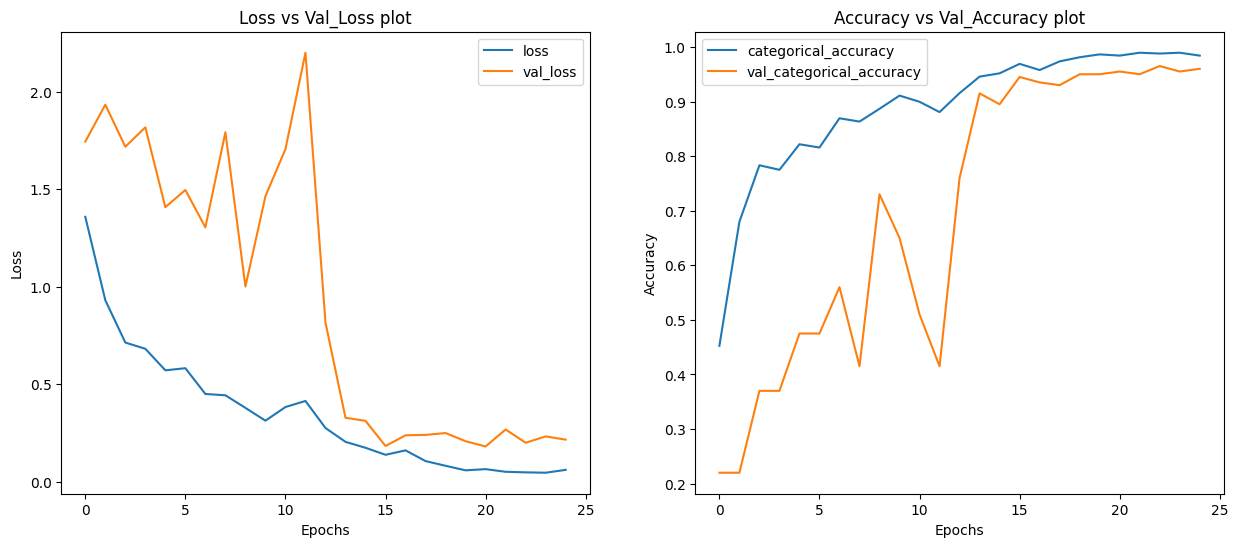

In [12]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model22',ip_img_size=(80,80),batch_size=4,
                          img_idx=[i for i in range(0,30,2)],augment=True)

### Model 23

In [7]:
EfficientNet = keras.applications.EfficientNetV2B0(include_top=False)
        
model = Sequential()
model.add(TimeDistributed(EfficientNet,input_shape=(15,80,80,3)))

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(50))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [8]:
model = compile_(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 1280)   5919312   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 1280)   5120      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 1280)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 1280)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                2

Hyperparameter values-
     1. Epoch: 25
     2. Crop size of Frame: (80, 80)
     3. Learning rate reduction factor: 0.2
     4. Batch Size: 4
     5. Minimum Learning Rate: 1e-05
     6. Image indices: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] having length 15
     7. Early Stopping monitor value: 1 - categorical_accuracy
     8. Early stopping patience value: 4
     9. Augmentation: True

The given batch size is 4 but the actual batch size post augmentation is 8 
Also the training data length is not 663 but 663*2= 1326, hence the number of batches is same.

# Training sequences = 663
# Validation sequences = 100
# Total number of batches per epoch = 166
 
----------------------------------------------------------------------------------------------------
Source path =  Project_data\train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.3190 - categorical_accuracy: 0.4728Source path =  Project_data\val ; batch size = 4

Epoch 1: s

166/166 [==============================] - 91s 551ms/step - loss: 0.0267 - categorical_accuracy: 0.9985 - val_loss: 0.1986 - val_categorical_accuracy: 0.9550 - lr: 4.0000e-05
Epoch 18/25
166/166 [==============================] - ETA: 0s - loss: 0.0267 - categorical_accuracy: 0.9985
Epoch 18: saving model to Model23_2023-01-0513_37_43.480847\Model23-epoch_00018-loss_0.02665-cat_acc_0.99849-val_loss_0.16793-val_acc_0.95500.h5

Epoch 18: ReduceLROnPlateau reducing learning rate to 1e-05.
166/166 [==============================] - 92s 556ms/step - loss: 0.0267 - categorical_accuracy: 0.9985 - val_loss: 0.1679 - val_categorical_accuracy: 0.9550 - lr: 4.0000e-05
 
Since the Accuracy was not increasing for the past 4 epochs, Early stopping is in action to stop the training by 18 instead of 25
 


<span style='color:lime'>**###################################### Model Training Completed by Early stopping ######################################**</span>

<span style='color:brown'>**Model performance across Epochs**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
1      1.319012              0.472810  1.832096                     0.200   
2      0.910096              0.694109  1.961865                     0.190   
3      0.642828              0.796072  1.154216                     0.480   
4      0.500205              0.848187  1.008332                     0.645   
5      0.281360              0.925982  2.305017                     0.180   
6      0.266740              0.925227  1.671378                     0.400   
7      0.241557              0.933535  1.848183                     0.170   
8      0.112036              0.975831  0.164145                     0.955   
9      0.067726              0.984894  0.217963                     0.935   
10     0.066100              0.987160  0.363370                     0.910   
11     0.043102              0.990181  0.188155                     0.960   
12     0.037922              0.993202  0.127361                     0.965   
13     0.042185              0.994713  0.152927                     0.960   
14     0.026264              0.999245  0.226933                     0.930   
15     0.027547              0.999245  0.125314                     0.975   
16     0.028665              0.998489  0.168404                     0.965   
17     0.026694              0.998489  0.198557                     0.955   
18     0.026651              0.998489  0.167928                     0.955   

            lr  Acc_val-acc_diff  
Epoch                             
1      0.00100          0.272810  
2      0.00100          0.504109  
3      0.00100          0.316072  
4      0.00100          0.203187  
5      0.00100          0.745982  
6      0.00100          0.525227  
7      0.00100          0.763535  
8      0.00020          0.020831  
9      0.00020          0.049894  
10     0.00020          0.077160  
11     0.00020          0.030181  
12     0.00004          0.028202  
13     0.00004          0.034713  
14     0.00004          0.069245  
15     0.00004          0.024245  
16     0.00004          0.033489  
17     0.00004          0.043489  
18     0.00004          0.043489

<span style='color:green'>**Model having min difference between the Accuracy and Validation Accuracy when Validation Accuracy is greater than 70% is in the Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
8      0.112036              0.975831  0.164145                     0.955   

           lr  Acc_val-acc_diff  
Epoch                            
8      0.0002          0.020831

<span style='color:brown'>**Model having highest validation Accuracy is in Epoch number:**</span>

loss  categorical_accuracy  val_loss  val_categorical_accuracy  \
Epoch                                                                       
15     0.027547              0.999245  0.125314                     0.975   

            lr  Acc_val-acc_diff  
Epoch                             
15     0.00004          0.024245

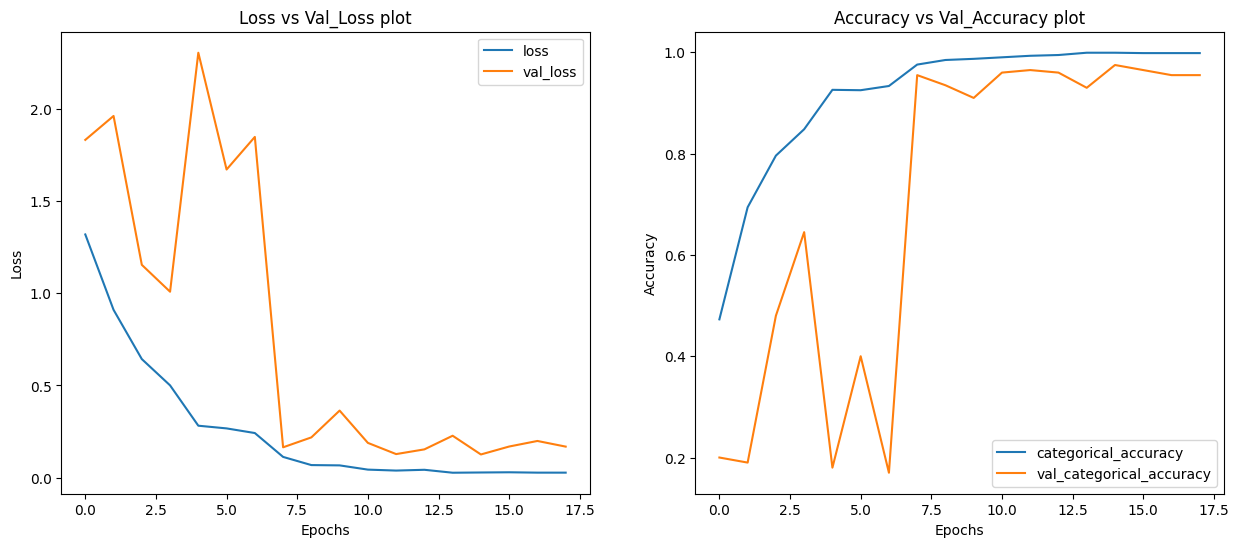

In [9]:
Model_history=train_model(model,epoch=25,train_doc=train_doc,val_doc=val_doc,
                           name='Model23',ip_img_size=(80,80),batch_size=4,
                          img_idx=[i for i in range(0,30,2)],augment=True)

## <center> Final result Classification

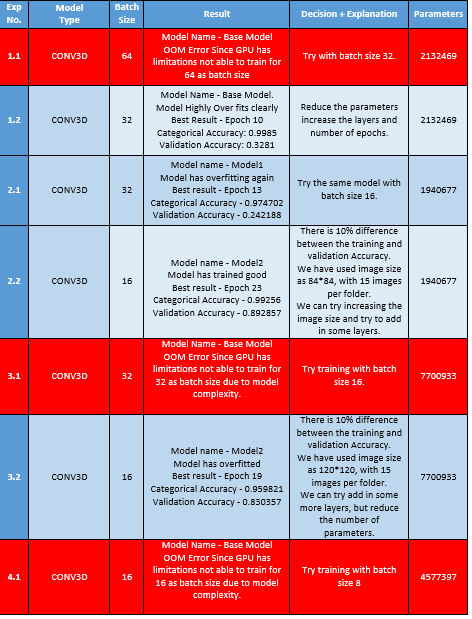
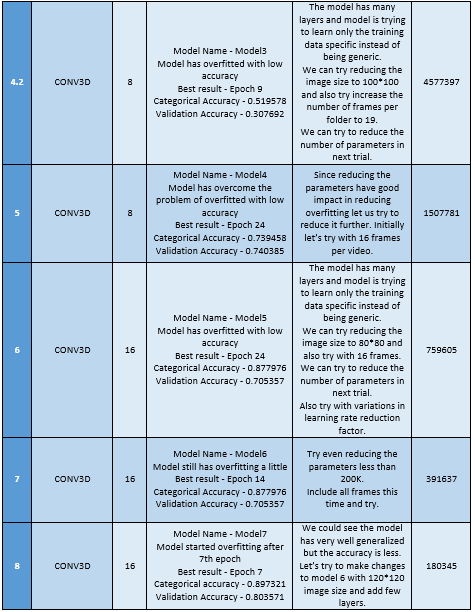
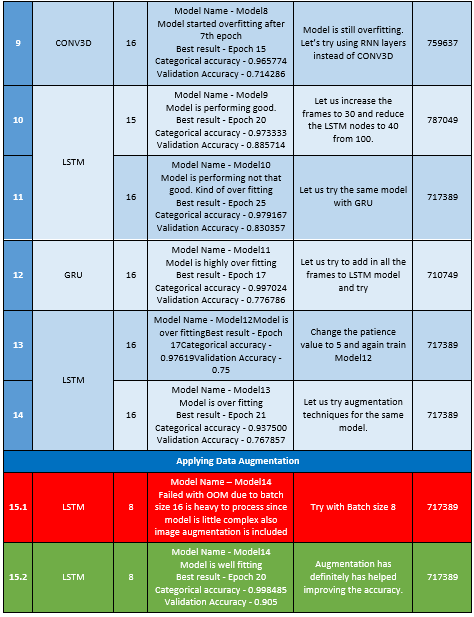
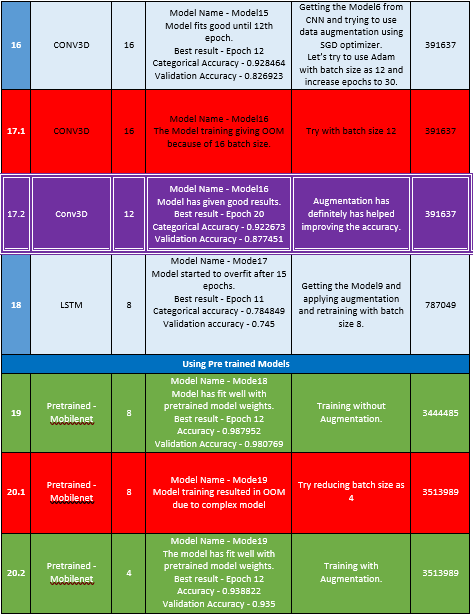
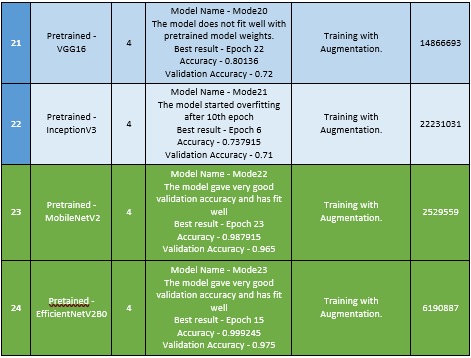

<b>From above table we could see that its Model16 (CONV3D) having Accuracy as 92.2% and Validation Accuracy 87.7% at 20th epoch with less number of parameters (3,91,637) only. Also the model size is just 4.60 MB only.
Hence we consider this as the best model with least number of parameters as possible.

## <center> Model Evaluation / Prediction

In [6]:
best_model = keras.models.load_model(r"S:\PG DS\Deep learning\Case Study\Model16_2023-01-0310_37_01.387946\Model16-epoch_00020-loss_0.25593-cat_acc_0.92267-val_loss_0.34230-val_acc_0.87745.h5")

In [7]:
best_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 16, 80, 80, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv3d_input'}},
  {'class_name': 'Conv3D',
   'config': {'name': 'conv3d',
    'trainable': True,
    'batch_input_shape': (None, 16, 80, 80, 3),
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3, 3),
    'strides': (1, 1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1, 1),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Activation',
   'config': {'name': 'activation',
    'trainable': 

### Prediction on training data

In [14]:
train_path = r'Project_data\train'
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
test_batch = generator(source_path=train_path,folder_list=train_doc,ip_img_size=(80,80),
                       img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29])
batch_data, batch_labels =next(test_batch)

Source path =  Project_data\train ; batch size = 16


In [15]:
# Training data
print(np.argmax(batch_labels,axis=1))

[3 3 0 2 0 3 4 0 2 0 2 1 1 2 3 2]


In [16]:
# Prediction
print(np.argmax(best_model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 0s 65ms/step
[3 3 0 2 0 3 4 0 2 0 2 1 1 2 3 2]


### Prediction on validation data

In [27]:
# Lets try with validation data
val_path = r'Project_data\val'
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
tval_batch = generator(source_path=val_path,folder_list=val_doc,ip_img_size=(80,80),
                       img_idx=[1, 3, 5, 7, 9, 11, 13, 15, 16, 17, 19, 21, 23, 25, 27, 29])
batch_data, batch_labels =next(tval_batch)

Source path =  Project_data\val ; batch size = 16


In [28]:
# validation data
print(np.argmax(batch_labels,axis=1))

[3 0 4 1 4 2 2 2 3 1 0 3 2 2 1 3]


In [29]:
# Prediction
print(np.argmax(best_model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 0s 42ms/step
[3 0 4 1 4 2 2 2 3 1 0 3 2 0 1 3]


In [30]:
batch_data, batch_labels =next(test_batch)
# validation data
print("Original class label:",np.argmax(batch_labels,axis=1))
# Prediction
print("\nPredicted class label by the model: ",np.argmax(best_model.predict(batch_data[:,:,:,:,:]),axis=1))

Original class label: [4 0 0 1 0 2 4 3 1 4 4 1 0 3 0 0]
1/1 [==============================] - 0s 42ms/step

Predicted class label by the model:  [4 0 0 1 0 2 4 3 1 4 4 1 0 3 0 0]


In [31]:
batch_data, batch_labels =next(test_batch)
# validation data
print("Original class label:",np.argmax(batch_labels,axis=1))
# Prediction
print("\nPredicted class label by the model: ",np.argmax(best_model.predict(batch_data[:,:,:,:,:]),axis=1))

Original class label: [0 3 0 2 0 2 4 4 3 3 3 1 3 2 1 2]
1/1 [==============================] - 0s 41ms/step

Predicted class label by the model:  [0 3 0 2 0 2 4 4 3 3 4 1 3 2 1 2]


In [32]:
batch_data, batch_labels =next(test_batch)
# validation data
print("Original class label:",np.argmax(batch_labels,axis=1))
# Prediction
print("\nPredicted class label by the model: ",np.argmax(best_model.predict(batch_data[:,:,:,:,:]),axis=1))

Original class label: [4 3 3 3 1 3 2 2 4 1 0 1 0 1 1 4]
1/1 [==============================] - 0s 38ms/step

Predicted class label by the model:  [4 3 3 3 1 3 2 2 4 1 0 1 0 1 1 4]
